In [1]:
#!python -m pip install torch
import torch
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
#!python -m pip install tensorflow
import auto_encoder
import math
import bisect
import pickle
import copy
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed1(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

def seed2(num):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=100)
    bx, bz = np.squeeze(np.split(sample,2, axis = 1))
    bx = [int(i*num) for i in bx]
    bz = [int(i*num) for i in bz]
    array = []
    for i in range (100):
        array.append(bx[i]*num+bz[i])
    return array

pts1 = seed1(10000)
pts2 = seed2(100)
data_2 = '2_qubit_crit_data_1.npz'
print(pts1)
print()
#print_points(data_2, 2, pts1)
print(pts2)
print()
#print_points(data_2, 2, pts2)



[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 3000, 3010, 3020, 3030, 3040, 3050, 3060, 3070, 3080, 3090, 4000, 4010, 4020, 4030, 4040, 4050, 4060, 4070, 4080, 4090, 5000, 5010, 5020, 5030, 5040, 5050, 5060, 5070, 5080, 5090, 6000, 6010, 6020, 6030, 6040, 6050, 6060, 6070, 6080, 6090, 7000, 7010, 7020, 7030, 7040, 7050, 7060, 7070, 7080, 7090, 8000, 8010, 8020, 8030, 8040, 8050, 8060, 8070, 8080, 8090, 9000, 9010, 9020, 9030, 9040, 9050, 9060, 9070, 9080, 9090]

[8937, 2350, 2660, 597, 4657, 6800, 6524, 8563, 9607, 9017, 8808, 7780, 1139, 2061, 6927, 8456, 789, 4170, 6051, 3653, 8154, 8630, 2811, 4521, 4068, 1014, 3541, 4440, 3469, 3873, 677, 1610, 7204, 4333, 7043, 9881, 8066, 3902, 3145, 6191, 9594, 5542, 3006, 9286, 805, 4895, 2593, 7131, 2716, 7567, 1519, 2222, 7809, 3720, 1903, 9487, 5990, 85, 1788, 455, 7923, 283, 5748, 6778, 6498, 5284, 6692, 5835, 6272, 7679, 5444, 

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 


In [4]:
def error_points(predicted, truth, num):
    pred = np.sum(predicted,axis=1)
    tru = np.sum(truth,axis=1)
    diffs = abs(((pred+1) - (tru+1))/(tru+1))
    points = (-np.asarray(diffs)).argsort()[:num]
    return points


In [5]:
# def mean_error(predicted, truth):
#     diffs = abs(((np.sum(predicted,axis=1)+1) - (np.sum(truth,axis=1)+1))/(np.sum(truth,axis=1)+1)
#     return np.mean(np.mean(diffs),axis=1)

# def max_error(predicted, truth):
#     diffs = abs((predicted+1) - (truth+1))/(truth+1)
#     array = np.mean(diffs, axis=1)
#     return np.sort(array)[np.size(array)-1]
                
def mean_error(predicted, truth):
    pred = np.sum(predicted,axis=1)
    tru = np.sum(truth,axis=1)
    diffs = abs(((pred+1) - (tru+1))/(tru+1))
    return np.mean(diffs) 

def max_error(predicted, truth):
    pred = np.sum(predicted,axis=1)
    tru = np.sum(truth,axis=1)
    diffs = abs((pred+1) - (tru+1))/(tru+1)
    return np.sort(diffs)[np.size(diffs)-1]

In [6]:
def error_data(pred, tru):
    diffs = abs(((pred+1) - (tru+1))/(tru+1))
    return np.mean(diffs, axis=1)


def error_mag(mag, mag_t):
    return abs(((mag+1) - (mag_t+1))/(mag_t+1))



In [7]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [8]:
def expand_pool(old_pool, error_points, max_pool_size):
    for i in error_points:
        num = int(i)
        if(i not in old_pool):
            bisect.insort(old_pool,i)
        else:
            Bz_low_num = num-1
            Bz_high_num= num+1
            Bz_low_flag=True
            Bz_high_flag=True
            
            Bx_low_num = int(num-math.sqrt(max_pool_size))
            Bx_high_num= int(num+math.sqrt(max_pool_size))
            Bx_low_flag=True
            Bx_high_flag=True
            
            while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
                if(Bz_low_flag):
                    if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                        Bz_low_flag=False
                    elif(Bz_low_num not in old_pool):
                        bisect.insort(old_pool,Bz_low_num)
                        Bz_low_flag=False
                    else:
                        Bz_low_num-=1
                if(Bz_high_flag):
                    if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                        Bz_high_flag=False
                    elif(Bz_high_num not in old_pool):
                        bisect.insort(old_pool, Bz_high_num)
                        Bz_high_flag=False
                    else:
                        Bz_high_num+=1
                if(Bx_low_flag):
                    if(Bx_low_num<=0):
                        Bx_low_flag=False
                    elif(Bx_low_num not in old_pool):
                        bisect.insort(old_pool, Bx_low_num)
                        Bx_low_flag=False
                    else:
                        Bx_low_num-=int(math.sqrt(max_pool_size))
                if(Bx_high_flag):
                    if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                        Bx_high_flag=False
                    elif(Bx_high_num not in old_pool):
                        bisect.insort(old_pool, Bx_high_num)
                        Bx_high_flag=False
                    else:
                        Bx_high_num+=int(math.sqrt(max_pool_size))    
                    
    return old_pool

In [15]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data_1.npz'
data_4 = '4_qubit_crit_data_1.npz'
data_6 = '6_qubit_crit_data_1.npz'
data_7 = '7_qubit_crit_data_1.npz'
data_8 = '8_qubit_crit_data.npz'

v_data_2 = '2_qubit_val_data.npz'
v_data_4 = '4_qubit_val_data.npz'
v_data_7 = '7_qubit_val_data.npz'
v_data_6 = '6_qubit_val_data.npz'

data_3 = '3_qubit_test_data.npz'
data_5 = '5_qubit_test_data.npz'
data_10 = '10_qubit_test_data.npz'

t_data_2 = '2_qubit_test_data.npz'
t_data_4 = '4_qubit_test_data.npz'
t_data_7 = '7_qubit_test_data.npz'
t_data_6 = '6_qubit_test_data.npz'
t_data_8 = '8_qubit_test_data.npz'


#     val_data_9 = get_dataset(data_9, 9, pool_size)

validation_n_sizes = [6,8]
mps_size = 5
device = torch.device("cpu")
model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_sizes = [2,4,7]
val_sizes = [6,8,2,4,7]

pool_size = 10000

val_size = 1089

pts = seed2(100)
error_p = []
magnetization_6 = []
wave_func_6 = []
final_weights = []
final_grads = []

val_data_2 = get_dataset(v_data_2, 2, val_size)
val_data_4 = get_dataset(v_data_4, 4, val_size)
val_data_7 = get_dataset(v_data_7, 7, val_size)
val_data_6 = get_dataset(v_data_6, 6, 2500)
val_data_8 = get_dataset(data_8, 8, 2500)

active_val_6 = get_dataset(data_6, 6, 10000)


test_data_3 = get_dataset(data_3, 3, pool_size)
test_data_5 = get_dataset(data_5, 5, 2500)
test_data_10 = get_dataset(data_10, 10, 100)
test_data_2 = get_dataset(t_data_2, 2, 1681)
test_data_4 = get_dataset(t_data_4, 4, 1681)
test_data_7 = get_dataset(t_data_7, 7, 1681)
test_data_6 = get_dataset(t_data_6, 6, 1681)
test_data_8 = get_dataset(t_data_8, 8, 1681)


val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]


val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
val_2 = next(iter(val_loaders[2]))
val_4 = next(iter(val_loaders[3]))
val_7 = next(iter(val_loaders[4]))

stop = 500
runs = 0
increase_points = 5
sizes = []

In [27]:
stop = 500
runs = 24
increase_points = 7
model.load_state_dict(torch.load("Active_lhc.pt"))
mag_loaders = torch.load('mag_loaders_lhc.pth')
model.eval()
magnon_6 = np.load('magnetization_6_lhc.npy')
magnetization_6 = magnon_6.tolist()
pots = np.load('pts_lhc.npy')   
pts = pots.tolist()
errr_p = np.load('error_p_lhc.npy')
error_p = errr_p.tolist()



FileNotFoundError: [Errno 2] No such file or directory: 'pts_lhc.npy'

In [17]:
while(True):
    runs = runs+1
    increase_points = 4 + (len(pts)/100)   
        
    training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    sizes.append(len(pts))    
        
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [test_data_2, test_data_3, test_data_4, test_data_5, active_val_6,test_data_7, test_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

    magnetization_6.append(mag_6)
    
    final_weights.append(model.encoder[6].weight)
    final_grads.append(model.encoder[6].weight.grad)

    error_pts = error_points(data_y_6, data_y_6_t, increase_points)
    print("ERROR POINTS:")
    print_points(data_6, 6, error_pts)

    error_p.append(error_data(data_y_6,data_y_6_t))

    new_err = mean_error(data_y_6,data_y_6_t)
    new_diff = max_error(data_y_6,data_y_6_t) - new_err
    
    if(len(pts)<stop):
        pts = expand_pool(pts, error_pts, pool_size)
        print("NEW SET: ")
        print(pts)
        print()
        print("_________________________________")
        prev_err = new_err
        prev_diff = new_diff
    else:
        break


Training Validation  2
Epoch 2 : 	 Training_Error: 0.04887 	 Val Error: 0.06952
********************************************************************************
2_qubit_loss: 0.00570 	 	 |4_qubit_loss: 0.01377 	 	 |7_qubit_loss: 0.02940 	 	 |
********************************************************************************
6_qubit_loss: 0.01185 	 	 |8_qubit_loss: 0.02467 	 	 |2_qubit_loss: 0.00625 	 	 |4_qubit_loss: 0.00787 	 	 |7_qubit_loss: 0.01888 	 	 |



Epoch 4 : 	 Training_Error: 0.08469 	 Val Error: 0.08002
********************************************************************************
2_qubit_loss: 0.00580 	 	 |4_qubit_loss: 0.02047 	 	 |7_qubit_loss: 0.05842 	 	 |
********************************************************************************
6_qubit_loss: 0.01368 	 	 |8_qubit_loss: 0.03065 	 	 |2_qubit_loss: 0.00555 	 	 |4_qubit_loss: 0.00762 	 	 |7_qubit_loss: 0.02252 	 	 |



Epoch 6 : 	 Training_Error: 0.05143 	 Val Error: 0.09789
****************************************

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/packages/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.p

ERROR POINTS:
[(0.0, 0.01), (0.020202020202020204, 0.01), (0.0, 0.0301010101010101), (0.04040404040404041, 0.01), (0.020202020202020204, 0.0301010101010101)]
NEW SET: 
[0, 1, 100, 101, 200, 3650, 8800, 1302, 9477, 1456, 7216, 4661, 868, 7560, 5899, 2596, 6303, 9338, 2380, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 8974, 2694, 4228, 4187, 3390, 4334, 198, 9271, 3006, 9126, 8269, 1109, 2436, 3253, 4841, 4505, 3489, 5042, 1047, 6754, 6930, 633, 2215, 5144, 1297, 8719, 922, 3748, 8004, 7017, 4001, 6532, 9755, 3579, 18, 7770, 3946, 1785, 773, 4482, 420, 4739, 8666, 7135, 2778, 6831, 5488, 1849, 8364, 7672, 8545, 9851, 6240, 265, 3821, 9537, 3167, 2084, 1907, 9614, 1557, 5962, 5376, 6483, 7363, 6093, 5586]

_________________________________
Training Validation  3
Epoch 2 : 	 Training_Error: 0.04113 	 Val Error: 0.06237
********************************************************************************
2_qubit_loss: 0.00463 	 	

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/packages/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.p

ERROR POINTS:
[(0.9696969696969697, 0.01), (0.9494949494949496, 0.01), (0.98989898989899, 0.01), (0.9292929292929294, 0.01), (1.0101010101010102, 0.01)]
NEW SET: 
[0, 1, 100, 101, 200, 3650, 4800, 8800, 1302, 9477, 1456, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 8974, 2694, 4228, 4187, 3390, 4334, 198, 9271, 3006, 9126, 8269, 1109, 2436, 3253, 4841, 4505, 3489, 5042, 1047, 6754, 6930, 633, 2215, 5144, 1297, 8719, 922, 3748, 8004, 7017, 4001, 6532, 9755, 3579, 18, 7770, 3946, 1785, 773, 4482, 420, 4739, 5000, 8666, 7135, 2778, 6831, 5488, 1849, 8364, 7672, 8545, 9851, 6240, 265, 3821, 9537, 3167, 2084, 1907, 9614, 1557, 4900, 5962, 5376, 6483, 7363, 6093, 5586]

_________________________________
Training Validation  4
Epoch 2 : 	 Training_Error: 0.05257 	 Val Error: 0.04717
********************************************************************************


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/packages/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.p

ERROR POINTS:
[(0.7070707070707072, 0.050202020202020206), (0.686868686868687, 0.050202020202020206), (0.7272727272727273, 0.050202020202020206), (0.7272727272727273, 0.0703030303030303), (0.7474747474747475, 0.0703030303030303)]
NEW SET: 
[0, 1, 100, 101, 200, 3650, 4800, 8800, 1302, 9477, 1456, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3502, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 8974, 2694, 4228, 4187, 3390, 4334, 198, 9271, 3006, 9126, 8269, 1109, 2436, 3253, 3402, 3602, 3703, 4841, 4505, 3489, 5042, 1047, 3603, 6754, 6930, 633, 2215, 5144, 1297, 8719, 922, 3748, 8004, 7017, 4001, 6532, 9755, 3579, 18, 7770, 3946, 1785, 773, 4482, 420, 4739, 5000, 8666, 7135, 2778, 6831, 5488, 1849, 8364, 7672, 8545, 9851, 6240, 265, 3821, 9537, 3167, 2084, 1907, 9614, 1557, 4900, 5962, 5376, 6483, 7363, 6093, 5586]

_________________________________
Training Validation  5
Epoch 2 : 	 Training_Error: 0.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x145f2b8793a0>
Traceback (most recent call last):
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/jet/home/jszacha1/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.0, 0.01), (0.020202020202020204, 0.01), (0.04040404040404041, 0.01), (0.0, 0.0301010101010101), (0.06060606060606061, 0.01)]
NEW SET: 
[0, 1, 2, 3, 100, 101, 102, 200, 201, 300, 301, 3650, 4800, 8800, 1302, 9477, 1456, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3502, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 8974, 2694, 4228, 4187, 3390, 4334, 198, 9271, 3006, 9126, 8269, 1109, 2436, 3253, 3402, 3602, 3703, 4841, 4505, 3489, 5042, 1047, 3603, 6754, 6930, 633, 2215, 5144, 1297, 8719, 922, 3748, 8004, 7017, 4001, 6532, 9755, 3579, 18, 7770, 3946

Model converged!
VALIDATION LOSS ITERATION:  7
6 	 0.003107416909188032
8 	 0.007854850962758064
2 	 0.0006296045612543821
4 	 0.0016572056338191032
7 	 0.004952531307935715
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(1.1515151515151516, 0.17080808080808083), (1.1313131313131315, 0.17080808080808083), (1.1313131313131315, 0.15070707070707073), (1.1717171717171717, 0.19090909090909092), (1.1717171717171717, 0.17080808080808083)]
NEW SET: 
[0, 1, 2, 3, 100, 101, 102, 200, 201, 300, 301, 3650, 4800, 8800, 1302, 9477, 1456, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3502, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 52

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(1.3333333333333335, 0.23111111111111113), (1.3535353535353536, 0.23111111111111113), (1.3131313131313131, 0.21101010101010104), (1.3131313131313131, 0.23111111111111113), (1.292929292929293, 0.21101010101010104)]
NEW SET: 
[0, 1, 2, 3, 100, 101, 102, 200, 201, 300, 301, 3605, 3650, 4800, 8800, 1302, 9477, 1456, 3702, 3704, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3403, 3502, 3503, 3601, 3604, 3701, 3705, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 8974, 2694, 4228, 4187, 3390, 4334, 198, 9271, 3006, 9126, 8269, 1109, 2436, 3253, 3402, 3602, 3703

Epoch 2 : 	 Training_Error: 0.04008 	 Val Error: 0.06903
********************************************************************************
2_qubit_loss: 0.00575 	 	 |4_qubit_loss: 0.01394 	 	 |7_qubit_loss: 0.02039 	 	 |
********************************************************************************
6_qubit_loss: 0.01379 	 	 |8_qubit_loss: 0.02221 	 	 |2_qubit_loss: 0.00609 	 	 |4_qubit_loss: 0.00875 	 	 |7_qubit_loss: 0.01820 	 	 |



Epoch 4 : 	 Training_Error: 0.03593 	 Val Error: 0.03786
********************************************************************************
2_qubit_loss: 0.00397 	 	 |4_qubit_loss: 0.01133 	 	 |7_qubit_loss: 0.02063 	 	 |
********************************************************************************
6_qubit_loss: 0.00723 	 	 |8_qubit_loss: 0.01253 	 	 |2_qubit_loss: 0.00336 	 	 |4_qubit_loss: 0.00458 	 	 |7_qubit_loss: 0.01016 	 	 |



Epoch 6 : 	 Training_Error: 0.02748 	 Val Error: 0.03457
***************************************************************

Epoch 2 : 	 Training_Error: 0.06690 	 Val Error: 0.08965
********************************************************************************
2_qubit_loss: 0.00644 	 	 |4_qubit_loss: 0.01538 	 	 |7_qubit_loss: 0.04508 	 	 |
********************************************************************************
6_qubit_loss: 0.01791 	 	 |8_qubit_loss: 0.03213 	 	 |2_qubit_loss: 0.00532 	 	 |4_qubit_loss: 0.00949 	 	 |7_qubit_loss: 0.02481 	 	 |



Epoch 4 : 	 Training_Error: 0.03360 	 Val Error: 0.02081
********************************************************************************
2_qubit_loss: 0.00298 	 	 |4_qubit_loss: 0.01297 	 	 |7_qubit_loss: 0.01765 	 	 |
********************************************************************************
6_qubit_loss: 0.00446 	 	 |8_qubit_loss: 0.00632 	 	 |2_qubit_loss: 0.00154 	 	 |4_qubit_loss: 0.00284 	 	 |7_qubit_loss: 0.00565 	 	 |



Epoch 6 : 	 Training_Error: 0.03982 	 Val Error: 0.03682
***************************************************************

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.8484848484848485, 0.01), (0.8686868686868687, 0.01), (0.8282828282828284, 0.01), (0.888888888888889, 0.01), (0.8080808080808082, 0.01)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 100, 101, 102, 103, 104, 200, 201, 202, 300, 301, 401, 501, 2935, 2936, 2937, 3036, 3037, 3605, 3650, 4800, 8800, 1302, 9477, 1456, 3702, 3704, 7216, 4661, 868, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3403, 3502, 3503, 3601, 3604, 3701, 3705, 3800, 3900, 4000, 4300, 4400, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 4100, 8974, 2694, 4228, 4187, 3390, 4334, 198, 4200, 4500, 4801, 9271, 3006, 9126, 

Epoch 14 : 	 Training_Error: 0.02943 	 Val Error: 0.02094
********************************************************************************
2_qubit_loss: 0.00250 	 	 |4_qubit_loss: 0.01000 	 	 |7_qubit_loss: 0.01693 	 	 |
********************************************************************************
6_qubit_loss: 0.00449 	 	 |8_qubit_loss: 0.00576 	 	 |2_qubit_loss: 0.00242 	 	 |4_qubit_loss: 0.00283 	 	 |7_qubit_loss: 0.00543 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  17
6 	 0.012071715667843819
8 	 0.02430623397231102
2 	 0.002344421809539199
4 	 0.005971246864646673
7 	 0.017337579280138016
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)


Epoch 10 : 	 Training_Error: 0.01983 	 Val Error: 0.01186
********************************************************************************
2_qubit_loss: 0.00243 	 	 |4_qubit_loss: 0.00654 	 	 |7_qubit_loss: 0.01086 	 	 |
********************************************************************************
6_qubit_loss: 0.00216 	 	 |8_qubit_loss: 0.00446 	 	 |2_qubit_loss: 0.00091 	 	 |4_qubit_loss: 0.00104 	 	 |7_qubit_loss: 0.00329 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  19
6 	 0.0029051541350781918
8 	 0.003683128161355853
2 	 0.0015353646595031023
4 	 0.001906371908262372
7 	 0.004379496909677982
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=Tru

Epoch 8 : 	 Training_Error: 0.02581 	 Val Error: 0.01579
********************************************************************************
2_qubit_loss: 0.00241 	 	 |4_qubit_loss: 0.00916 	 	 |7_qubit_loss: 0.01425 	 	 |
********************************************************************************
6_qubit_loss: 0.00267 	 	 |8_qubit_loss: 0.00561 	 	 |2_qubit_loss: 0.00184 	 	 |4_qubit_loss: 0.00178 	 	 |7_qubit_loss: 0.00389 	 	 |



Epoch 10 : 	 Training_Error: 0.02192 	 Val Error: 0.01488
********************************************************************************
2_qubit_loss: 0.00237 	 	 |4_qubit_loss: 0.00888 	 	 |7_qubit_loss: 0.01067 	 	 |
********************************************************************************
6_qubit_loss: 0.00250 	 	 |8_qubit_loss: 0.00589 	 	 |2_qubit_loss: 0.00101 	 	 |4_qubit_loss: 0.00121 	 	 |7_qubit_loss: 0.00427 	 	 |



Epoch 12 : 	 Training_Error: 0.02141 	 Val Error: 0.00856
*************************************************************

Epoch 4 : 	 Training_Error: 0.01506 	 Val Error: 0.01045
********************************************************************************
2_qubit_loss: 0.00168 	 	 |4_qubit_loss: 0.00448 	 	 |7_qubit_loss: 0.00889 	 	 |
********************************************************************************
6_qubit_loss: 0.00196 	 	 |8_qubit_loss: 0.00377 	 	 |2_qubit_loss: 0.00074 	 	 |4_qubit_loss: 0.00101 	 	 |7_qubit_loss: 0.00297 	 	 |



Epoch 6 : 	 Training_Error: 0.01743 	 Val Error: 0.01015
********************************************************************************
2_qubit_loss: 0.00154 	 	 |4_qubit_loss: 0.00634 	 	 |7_qubit_loss: 0.00954 	 	 |
********************************************************************************
6_qubit_loss: 0.00186 	 	 |8_qubit_loss: 0.00378 	 	 |2_qubit_loss: 0.00074 	 	 |4_qubit_loss: 0.00096 	 	 |7_qubit_loss: 0.00281 	 	 |



Epoch 8 : 	 Training_Error: 0.02771 	 Val Error: 0.01696
***************************************************************

ERROR POINTS:
[(0.8484848484848485, 0.35171717171717176), (0.8484848484848485, 0.3718181818181818), (0.8484848484848485, 0.39191919191919194), (0.8484848484848485, 0.33161616161616164), (0.8484848484848485, 0.41202020202020206)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 20, 21, 22, 100, 101, 102, 103, 104, 200, 201, 202, 300, 301, 401, 501, 1202, 1301, 1303, 1400, 1402, 1403, 1500, 1502, 1503, 1600, 1602, 1700, 1800, 2100, 2200, 2201, 2300, 2301, 2302, 2700, 2800, 2900, 2935, 2936, 2937, 3000, 3036, 3037, 3100, 3200, 3201, 3300, 3302, 3400, 3500, 3600, 3605, 3650, 4800, 8800, 1302, 9477, 1456, 3700, 3702, 3704, 7216, 4661, 868, 1900, 4700, 7560, 5899, 2596, 6303, 9338, 2380, 3403, 3502, 3503, 3601, 3604, 3701, 3705, 3800, 3900, 4000, 4300, 4400, 4600, 5758, 5627, 7492, 7881, 2910, 6129, 5243, 6613, 9023, 7975, 8452, 525, 359, 9912, 1611, 8191, 2895, 4908, 2124, 4100, 8974, 2694, 4228, 4187, 3390, 4334, 198, 4200, 4500, 4801, 9271, 3006, 9126, 8269, 1109, 2000, 2400, 2401, 2436, 2500, 2600, 3102, 32

Epoch 10 : 	 Training_Error: 0.03548 	 Val Error: 0.03953
********************************************************************************
2_qubit_loss: 0.00482 	 	 |4_qubit_loss: 0.01034 	 	 |7_qubit_loss: 0.02032 	 	 |
********************************************************************************
6_qubit_loss: 0.00691 	 	 |8_qubit_loss: 0.01078 	 	 |2_qubit_loss: 0.00746 	 	 |4_qubit_loss: 0.00554 	 	 |7_qubit_loss: 0.00883 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  26
6 	 0.0006036254926584661
8 	 0.00032119167735800147
2 	 0.003235091222450137
4 	 0.001090675825253129
7 	 0.00030452708597294986
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=

Epoch 6 : 	 Training_Error: 0.01377 	 Val Error: 0.01182
********************************************************************************
2_qubit_loss: 0.00125 	 	 |4_qubit_loss: 0.00386 	 	 |7_qubit_loss: 0.00865 	 	 |
********************************************************************************
6_qubit_loss: 0.00219 	 	 |8_qubit_loss: 0.00432 	 	 |2_qubit_loss: 0.00077 	 	 |4_qubit_loss: 0.00108 	 	 |7_qubit_loss: 0.00346 	 	 |



Epoch 8 : 	 Training_Error: 0.01852 	 Val Error: 0.01776
********************************************************************************
2_qubit_loss: 0.00242 	 	 |4_qubit_loss: 0.00825 	 	 |7_qubit_loss: 0.00786 	 	 |
********************************************************************************
6_qubit_loss: 0.00324 	 	 |8_qubit_loss: 0.00703 	 	 |2_qubit_loss: 0.00059 	 	 |4_qubit_loss: 0.00170 	 	 |7_qubit_loss: 0.00520 	 	 |



Epoch 10 : 	 Training_Error: 0.01719 	 Val Error: 0.00796
**************************************************************

Epoch 2 : 	 Training_Error: 0.01101 	 Val Error: 0.00691
********************************************************************************
2_qubit_loss: 0.00107 	 	 |4_qubit_loss: 0.00299 	 	 |7_qubit_loss: 0.00695 	 	 |
********************************************************************************
6_qubit_loss: 0.00121 	 	 |8_qubit_loss: 0.00237 	 	 |2_qubit_loss: 0.00081 	 	 |4_qubit_loss: 0.00078 	 	 |7_qubit_loss: 0.00174 	 	 |



Epoch 4 : 	 Training_Error: 0.01280 	 Val Error: 0.00886
********************************************************************************
2_qubit_loss: 0.00120 	 	 |4_qubit_loss: 0.00347 	 	 |7_qubit_loss: 0.00813 	 	 |
********************************************************************************
6_qubit_loss: 0.00144 	 	 |8_qubit_loss: 0.00300 	 	 |2_qubit_loss: 0.00129 	 	 |4_qubit_loss: 0.00087 	 	 |7_qubit_loss: 0.00227 	 	 |



Epoch 6 : 	 Training_Error: 0.02269 	 Val Error: 0.01542
***************************************************************

Epoch 14 : 	 Training_Error: 0.00889 	 Val Error: 0.00422
********************************************************************************
2_qubit_loss: 0.00092 	 	 |4_qubit_loss: 0.00219 	 	 |7_qubit_loss: 0.00578 	 	 |
********************************************************************************
6_qubit_loss: 0.00074 	 	 |8_qubit_loss: 0.00149 	 	 |2_qubit_loss: 0.00041 	 	 |4_qubit_loss: 0.00045 	 	 |7_qubit_loss: 0.00111 	 	 |



Epoch 16 : 	 Training_Error: 0.00895 	 Val Error: 0.00417
********************************************************************************
2_qubit_loss: 0.00086 	 	 |4_qubit_loss: 0.00305 	 	 |7_qubit_loss: 0.00504 	 	 |
********************************************************************************
6_qubit_loss: 0.00063 	 	 |8_qubit_loss: 0.00169 	 	 |2_qubit_loss: 0.00034 	 	 |4_qubit_loss: 0.00039 	 	 |7_qubit_loss: 0.00112 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  31
6 	 0.0012259576469659805
8 	 0.002510461490601301
2 	 0.0003603300428

Model converged!
VALIDATION LOSS ITERATION:  32
6 	 0.0023658655118197203
8 	 0.003982857801020145
2 	 0.0002576581318862736
4 	 0.001143499044701457
7 	 0.0030122397001832724
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.0, 2.0), (0.0, 1.97989898989899), (0.0, 1.9597979797979799), (0.0, 1.9396969696969697), (0.0, 1.9195959595959597)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 120, 195, 196, 197, 199, 200, 201, 202, 298, 300, 301, 401, 501, 900, 1000, 1100, 1200, 1202, 1300, 1301, 1303, 1400, 1402, 1403, 1500, 1502, 1503, 1600, 1

Epoch 4 : 	 Training_Error: 0.01161 	 Val Error: 0.01928
********************************************************************************
2_qubit_loss: 0.00086 	 	 |4_qubit_loss: 0.00321 	 	 |7_qubit_loss: 0.00753 	 	 |
********************************************************************************
6_qubit_loss: 0.00373 	 	 |8_qubit_loss: 0.00651 	 	 |2_qubit_loss: 0.00095 	 	 |4_qubit_loss: 0.00271 	 	 |7_qubit_loss: 0.00537 	 	 |



Epoch 6 : 	 Training_Error: 0.01002 	 Val Error: 0.00818
********************************************************************************
2_qubit_loss: 0.00135 	 	 |4_qubit_loss: 0.00283 	 	 |7_qubit_loss: 0.00584 	 	 |
********************************************************************************
6_qubit_loss: 0.00141 	 	 |8_qubit_loss: 0.00255 	 	 |2_qubit_loss: 0.00109 	 	 |4_qubit_loss: 0.00121 	 	 |7_qubit_loss: 0.00192 	 	 |



Epoch 8 : 	 Training_Error: 0.00803 	 Val Error: 0.00787
***************************************************************

Epoch 16 : 	 Training_Error: 0.01010 	 Val Error: 0.00627
********************************************************************************
2_qubit_loss: 0.00125 	 	 |4_qubit_loss: 0.00330 	 	 |7_qubit_loss: 0.00554 	 	 |
********************************************************************************
6_qubit_loss: 0.00102 	 	 |8_qubit_loss: 0.00213 	 	 |2_qubit_loss: 0.00075 	 	 |4_qubit_loss: 0.00078 	 	 |7_qubit_loss: 0.00158 	 	 |



Epoch 18 : 	 Training_Error: 0.00880 	 Val Error: 0.00928
********************************************************************************
2_qubit_loss: 0.00108 	 	 |4_qubit_loss: 0.00308 	 	 |7_qubit_loss: 0.00463 	 	 |
********************************************************************************
6_qubit_loss: 0.00170 	 	 |8_qubit_loss: 0.00370 	 	 |2_qubit_loss: 0.00028 	 	 |4_qubit_loss: 0.00095 	 	 |7_qubit_loss: 0.00265 	 	 |



Epoch 20 : 	 Training_Error: 0.00825 	 Val Error: 0.00782
************************************************************

Epoch 2 : 	 Training_Error: 0.00994 	 Val Error: 0.00663
********************************************************************************
2_qubit_loss: 0.00178 	 	 |4_qubit_loss: 0.00383 	 	 |7_qubit_loss: 0.00434 	 	 |
********************************************************************************
6_qubit_loss: 0.00108 	 	 |8_qubit_loss: 0.00204 	 	 |2_qubit_loss: 0.00114 	 	 |4_qubit_loss: 0.00082 	 	 |7_qubit_loss: 0.00155 	 	 |



Epoch 4 : 	 Training_Error: 0.00936 	 Val Error: 0.00779
********************************************************************************
2_qubit_loss: 0.00149 	 	 |4_qubit_loss: 0.00357 	 	 |7_qubit_loss: 0.00430 	 	 |
********************************************************************************
6_qubit_loss: 0.00138 	 	 |8_qubit_loss: 0.00290 	 	 |2_qubit_loss: 0.00050 	 	 |4_qubit_loss: 0.00082 	 	 |7_qubit_loss: 0.00219 	 	 |



Epoch 6 : 	 Training_Error: 0.00976 	 Val Error: 0.00485
***************************************************************

Model converged!
VALIDATION LOSS ITERATION:  38
6 	 0.0018606025259941816
8 	 0.0029629264026880264
2 	 0.0010389070957899094
4 	 0.0011903926497325301
7 	 0.0023540242109447718
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.686868686868687, 0.01), (0.7070707070707072, 0.01), (0.7272727272727273, 0.01), (0.6666666666666667, 0.01), (0.7474747474747475, 0.01)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 120, 195, 196, 197, 199, 200, 201, 202, 298, 300, 301, 400, 401, 500, 501, 600, 700, 800, 900, 1000, 1100, 1117, 1118, 1200, 1202, 1

Epoch 2 : 	 Training_Error: 0.01197 	 Val Error: 0.00737
********************************************************************************
2_qubit_loss: 0.00299 	 	 |4_qubit_loss: 0.00526 	 	 |7_qubit_loss: 0.00372 	 	 |
********************************************************************************
6_qubit_loss: 0.00104 	 	 |8_qubit_loss: 0.00227 	 	 |2_qubit_loss: 0.00186 	 	 |4_qubit_loss: 0.00058 	 	 |7_qubit_loss: 0.00162 	 	 |



Epoch 4 : 	 Training_Error: 0.01020 	 Val Error: 0.00729
********************************************************************************
2_qubit_loss: 0.00167 	 	 |4_qubit_loss: 0.00408 	 	 |7_qubit_loss: 0.00444 	 	 |
********************************************************************************
6_qubit_loss: 0.00119 	 	 |8_qubit_loss: 0.00263 	 	 |2_qubit_loss: 0.00095 	 	 |4_qubit_loss: 0.00066 	 	 |7_qubit_loss: 0.00186 	 	 |



Epoch 6 : 	 Training_Error: 0.00740 	 Val Error: 0.00448
***************************************************************

Model converged!
VALIDATION LOSS ITERATION:  41
6 	 0.0003266331914346665
8 	 0.0004927584086544812
2 	 0.0004821291076950729
4 	 0.00024813535856083035
7 	 0.0003919914015568793
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(1.0707070707070707, 0.01), (1.1313131313131315, 0.01), (1.0505050505050506, 0.01), (0.888888888888889, 0.11050505050505051), (1.090909090909091, 0.01)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 120, 195, 196, 197, 199, 200, 201, 202, 298, 300, 301, 400, 401, 500, 501, 600, 700, 800, 900, 1000, 1100, 1101, 1117

Epoch 2 : 	 Training_Error: 0.00802 	 Val Error: 0.00706
********************************************************************************
2_qubit_loss: 0.00170 	 	 |4_qubit_loss: 0.00325 	 	 |7_qubit_loss: 0.00307 	 	 |
********************************************************************************
6_qubit_loss: 0.00104 	 	 |8_qubit_loss: 0.00200 	 	 |2_qubit_loss: 0.00161 	 	 |4_qubit_loss: 0.00090 	 	 |7_qubit_loss: 0.00151 	 	 |



Epoch 4 : 	 Training_Error: 0.00980 	 Val Error: 0.00912
********************************************************************************
2_qubit_loss: 0.00181 	 	 |4_qubit_loss: 0.00405 	 	 |7_qubit_loss: 0.00395 	 	 |
********************************************************************************
6_qubit_loss: 0.00145 	 	 |8_qubit_loss: 0.00317 	 	 |2_qubit_loss: 0.00136 	 	 |4_qubit_loss: 0.00090 	 	 |7_qubit_loss: 0.00224 	 	 |



Epoch 6 : 	 Training_Error: 0.00996 	 Val Error: 0.00632
***************************************************************

Model converged!
VALIDATION LOSS ITERATION:  44
6 	 0.0009783849818632007
8 	 0.0013252918142825365
2 	 0.0005399067886173725
4 	 0.0007326875347644091
7 	 0.0011250311508774757
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.9292929292929294, 0.01), (0.7676767676767677, 0.01), (0.9090909090909092, 0.01), (0.7474747474747475, 0.01), (0.9494949494949496, 0.01)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 120, 195, 196, 197, 199, 200, 201, 202, 298, 300, 301, 400, 401, 500, 501, 600, 700, 701, 702, 800, 801, 802, 900, 901, 1000, 1001,

Epoch 2 : 	 Training_Error: 0.00958 	 Val Error: 0.01073
********************************************************************************
2_qubit_loss: 0.00194 	 	 |4_qubit_loss: 0.00399 	 	 |7_qubit_loss: 0.00366 	 	 |
********************************************************************************
6_qubit_loss: 0.00210 	 	 |8_qubit_loss: 0.00337 	 	 |2_qubit_loss: 0.00132 	 	 |4_qubit_loss: 0.00123 	 	 |7_qubit_loss: 0.00270 	 	 |



Epoch 4 : 	 Training_Error: 0.01271 	 Val Error: 0.01291
********************************************************************************
2_qubit_loss: 0.00242 	 	 |4_qubit_loss: 0.00489 	 	 |7_qubit_loss: 0.00540 	 	 |
********************************************************************************
6_qubit_loss: 0.00240 	 	 |8_qubit_loss: 0.00378 	 	 |2_qubit_loss: 0.00207 	 	 |4_qubit_loss: 0.00156 	 	 |7_qubit_loss: 0.00310 	 	 |



Epoch 6 : 	 Training_Error: 0.01108 	 Val Error: 0.00684
***************************************************************

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.787878787878788, 0.01), (0.7676767676767677, 0.01), (0.7474747474747475, 0.01), (0.7272727272727273, 0.01), (0.7070707070707072, 0.01)]
NEW SET: 
[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 120, 195, 196, 197, 199, 200, 201, 202, 298, 300, 301, 400, 401, 500, 501, 600, 700, 701, 702, 800, 801, 802, 900, 901, 902, 1000, 1001, 1002, 1100, 1101, 1117, 1118, 1200, 1201, 1202, 1214, 1215, 1216, 1300, 1301, 1303, 1304, 1400, 1401, 1402, 1403, 1410, 1500, 1502, 1503, 1509, 1510, 1511, 1600, 1602, 1604, 1609, 1610, 1612, 1613, 1614, 1700, 1710, 1711, 180

Epoch 2 : 	 Training_Error: 0.00762 	 Val Error: 0.00518
********************************************************************************
2_qubit_loss: 0.00134 	 	 |4_qubit_loss: 0.00304 	 	 |7_qubit_loss: 0.00323 	 	 |
********************************************************************************
6_qubit_loss: 0.00066 	 	 |8_qubit_loss: 0.00142 	 	 |2_qubit_loss: 0.00163 	 	 |4_qubit_loss: 0.00047 	 	 |7_qubit_loss: 0.00099 	 	 |



Epoch 4 : 	 Training_Error: 0.00829 	 Val Error: 0.00615
********************************************************************************
2_qubit_loss: 0.00137 	 	 |4_qubit_loss: 0.00308 	 	 |7_qubit_loss: 0.00384 	 	 |
********************************************************************************
6_qubit_loss: 0.00085 	 	 |8_qubit_loss: 0.00173 	 	 |2_qubit_loss: 0.00172 	 	 |4_qubit_loss: 0.00063 	 	 |7_qubit_loss: 0.00122 	 	 |



Epoch 6 : 	 Training_Error: 0.00834 	 Val Error: 0.00698
***************************************************************

Epoch 10 : 	 Training_Error: 0.00665 	 Val Error: 0.00789
********************************************************************************
2_qubit_loss: 0.00130 	 	 |4_qubit_loss: 0.00233 	 	 |7_qubit_loss: 0.00302 	 	 |
********************************************************************************
6_qubit_loss: 0.00123 	 	 |8_qubit_loss: 0.00271 	 	 |2_qubit_loss: 0.00151 	 	 |4_qubit_loss: 0.00060 	 	 |7_qubit_loss: 0.00184 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  50
6 	 0.000558519852347672
8 	 0.0006970998947508633
2 	 0.0005279084434732795
4 	 0.0004354053526185453
7 	 0.0006067369831725955
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=T

Epoch 2 : 	 Training_Error: 0.00891 	 Val Error: 0.00775
********************************************************************************
2_qubit_loss: 0.00164 	 	 |4_qubit_loss: 0.00310 	 	 |7_qubit_loss: 0.00416 	 	 |
********************************************************************************
6_qubit_loss: 0.00133 	 	 |8_qubit_loss: 0.00256 	 	 |2_qubit_loss: 0.00131 	 	 |4_qubit_loss: 0.00075 	 	 |7_qubit_loss: 0.00180 	 	 |



Epoch 4 : 	 Training_Error: 0.00897 	 Val Error: 0.01026
********************************************************************************
2_qubit_loss: 0.00155 	 	 |4_qubit_loss: 0.00276 	 	 |7_qubit_loss: 0.00466 	 	 |
********************************************************************************
6_qubit_loss: 0.00203 	 	 |8_qubit_loss: 0.00292 	 	 |2_qubit_loss: 0.00142 	 	 |4_qubit_loss: 0.00143 	 	 |7_qubit_loss: 0.00246 	 	 |



Epoch 6 : 	 Training_Error: 0.00691 	 Val Error: 0.00659
***************************************************************

Epoch 8 : 	 Training_Error: 0.00664 	 Val Error: 0.00757
********************************************************************************
2_qubit_loss: 0.00082 	 	 |4_qubit_loss: 0.00186 	 	 |7_qubit_loss: 0.00396 	 	 |
********************************************************************************
6_qubit_loss: 0.00125 	 	 |8_qubit_loss: 0.00264 	 	 |2_qubit_loss: 0.00112 	 	 |4_qubit_loss: 0.00069 	 	 |7_qubit_loss: 0.00187 	 	 |



Epoch 10 : 	 Training_Error: 0.00651 	 Val Error: 0.00619
********************************************************************************
2_qubit_loss: 0.00092 	 	 |4_qubit_loss: 0.00235 	 	 |7_qubit_loss: 0.00324 	 	 |
********************************************************************************
6_qubit_loss: 0.00114 	 	 |8_qubit_loss: 0.00226 	 	 |2_qubit_loss: 0.00065 	 	 |4_qubit_loss: 0.00058 	 	 |7_qubit_loss: 0.00157 	 	 |



Epoch 12 : 	 Training_Error: 0.00597 	 Val Error: 0.00738
*************************************************************

Epoch 2 : 	 Training_Error: 0.00722 	 Val Error: 0.00787
********************************************************************************
2_qubit_loss: 0.00110 	 	 |4_qubit_loss: 0.00233 	 	 |7_qubit_loss: 0.00379 	 	 |
********************************************************************************
6_qubit_loss: 0.00141 	 	 |8_qubit_loss: 0.00270 	 	 |2_qubit_loss: 0.00095 	 	 |4_qubit_loss: 0.00082 	 	 |7_qubit_loss: 0.00199 	 	 |



Epoch 4 : 	 Training_Error: 0.00769 	 Val Error: 0.00705
********************************************************************************
2_qubit_loss: 0.00127 	 	 |4_qubit_loss: 0.00227 	 	 |7_qubit_loss: 0.00415 	 	 |
********************************************************************************
6_qubit_loss: 0.00122 	 	 |8_qubit_loss: 0.00205 	 	 |2_qubit_loss: 0.00139 	 	 |4_qubit_loss: 0.00077 	 	 |7_qubit_loss: 0.00162 	 	 |



Epoch 6 : 	 Training_Error: 0.00778 	 Val Error: 0.01007
***************************************************************

Epoch 14 : 	 Training_Error: 0.00759 	 Val Error: 0.00762
********************************************************************************
2_qubit_loss: 0.00149 	 	 |4_qubit_loss: 0.00264 	 	 |7_qubit_loss: 0.00346 	 	 |
********************************************************************************
6_qubit_loss: 0.00137 	 	 |8_qubit_loss: 0.00240 	 	 |2_qubit_loss: 0.00116 	 	 |4_qubit_loss: 0.00080 	 	 |7_qubit_loss: 0.00188 	 	 |



Epoch 16 : 	 Training_Error: 0.00641 	 Val Error: 0.00531
********************************************************************************
2_qubit_loss: 0.00108 	 	 |4_qubit_loss: 0.00225 	 	 |7_qubit_loss: 0.00309 	 	 |
********************************************************************************
6_qubit_loss: 0.00100 	 	 |8_qubit_loss: 0.00172 	 	 |2_qubit_loss: 0.00072 	 	 |4_qubit_loss: 0.00057 	 	 |7_qubit_loss: 0.00129 	 	 |



Epoch 18 : 	 Training_Error: 0.00676 	 Val Error: 0.00630
************************************************************

Epoch 2 : 	 Training_Error: 0.00674 	 Val Error: 0.00795
********************************************************************************
2_qubit_loss: 0.00113 	 	 |4_qubit_loss: 0.00242 	 	 |7_qubit_loss: 0.00319 	 	 |
********************************************************************************
6_qubit_loss: 0.00094 	 	 |8_qubit_loss: 0.00391 	 	 |2_qubit_loss: 0.00124 	 	 |4_qubit_loss: 0.00055 	 	 |7_qubit_loss: 0.00131 	 	 |



Epoch 4 : 	 Training_Error: 0.00602 	 Val Error: 0.01014
********************************************************************************
2_qubit_loss: 0.00097 	 	 |4_qubit_loss: 0.00188 	 	 |7_qubit_loss: 0.00318 	 	 |
********************************************************************************
6_qubit_loss: 0.00145 	 	 |8_qubit_loss: 0.00488 	 	 |2_qubit_loss: 0.00121 	 	 |4_qubit_loss: 0.00074 	 	 |7_qubit_loss: 0.00186 	 	 |



Epoch 6 : 	 Training_Error: 0.00614 	 Val Error: 0.01056
***************************************************************

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.5252525252525253, 0.01), (0.3434343434343435, 0.01), (0.32323232323232326, 0.01), (0.30303030303030304, 0.01), (0.36363636363636365, 0.01)]


In [18]:
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

In [19]:
print(mean_error(data_y_2,data_y_2_t), "&", mean_error(data_y_3,data_y_3_t), "&", mean_error(data_y_4,data_y_4_t), "&", mean_error(data_y_5,data_y_5_t), "&", mean_error(data_y_6,data_y_6_t), "&",  mean_error(data_y_7,data_y_7_t), "&", mean_error(data_y_8,data_y_8_t), "&", mean_error(data_y_10,data_y_10_t))

0.015277586 & 0.01133247 & 0.009970838 & 0.019444529 & 0.023134146 & 0.024157552 & 0.033834506 & 0.26928118


In [20]:
from tempfile import TemporaryFile

with open('magnetization_6_lhc.npy', 'wb') as f:
    np.save(f, magnetization_6)

with open('pts_lhc.npy', 'wb') as f:
    np.save(f, pts)   
    
with open('error_p_lhc.npy', 'wb') as f:
    np.save(f,error_p)

    
with open('sizes_lhc.npy', 'wb') as f:
    np.save(f, sizes)

with open('final_weights_lhc.npy','wb') as f:
    np.save(f, final_weights)
    
# with open('final_grads_pr.pt','wb') as f:
#     torch.save(f, final_grads)

torch.save(mag_loaders, 'mag_loaders_lhc.pth')    
torch.save(model.state_dict(), "Active_lhc.pt")

In [52]:
print("2: ", mean_error(data_y_2,data_y_2_t)*100)
print("3: ", mean_error(data_y_3,data_y_3_t)*100)
print("4: ", mean_error(data_y_4,data_y_4_t)*100)
print("5: ", mean_error(data_y_5,data_y_5_t)*100)
print("6: ", mean_error(data_y_6,data_y_6_t)*100)
print("7: ", mean_error(data_y_7,data_y_7_t)*100)
print("8: ", mean_error(data_y_8,data_y_8_t)*100)
print("10: ", mean_error(data_y_10,data_y_10_t)*100)

2:  1.0495517402887344
3:  2.8167027980089188
4:  0.4017195198684931
5:  0.5799085833132267
6:  0.2764268545433879
7:  0.20005821716040373
8:  0.19706329330801964
10:  0.15967930667102337


In [33]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
gpr.score(X, y)

0.36802938610173397

In [12]:
data_2 = '2_qubit_val_data.npz'
data_4 = '4_qubit_val_data.npz'
data_7 = '7_qubit_val_data.npz'


validation_n_sizes = [6,8]
mps_size = 5
device = torch.device("cpu")
model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_sizes = [2,4,7]
val_sizes = [6,8,2,4,7]

pool_size = 10000

val_size = 1089

val_data_2 = get_dataset(v_data_2, 2, val_size)
val_data_4 = get_dataset(v_data_4, 4, val_size)
val_data_7 = get_dataset(v_data_7, 7, val_size)
val_data_6 = get_dataset(data_6, 6, pool_size)
val_data_8 = get_dataset(data_8, 8, 2500)


test_data_3 = get_dataset(data_3, 3, pool_size)
test_data_5 = get_dataset(data_5, 5, 2500)
test_data_10 = get_dataset(data_10, 10, 100)

val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]


val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
val_2 = next(iter(val_loaders[2]))
val_4 = next(iter(val_loaders[3]))
val_7 = next(iter(val_loaders[4]))

if(True):    
    training_data_2 = get_dataset(data_2, 2, 1089)
    training_data_4 = get_dataset(data_4,4,1089)
    training_data_7 = get_dataset(data_7,7,1089) 

    training_data_2, val_data_2 = random_split(training_data_2, [980,109])
    training_data_4, val_data_4 = random_split(training_data_4, [980,109])
    training_data_7, val_data_7 = random_split(training_data_7, [980,109])
    
    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [test_data_2, test_data_3, test_data_4, test_data_5, test_data_6,test_data_7, test_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

print(mean_error(data_y_2,data_y_2_t), "&", mean_error(data_y_3,data_y_3_t), "&", mean_error(data_y_4,data_y_4_t), "&", mean_error(data_y_5,data_y_5_t), "&", mean_error(data_y_6,data_y_6_t), "&",  mean_error(data_y_7,data_y_7_t), "&", mean_error(data_y_8,data_y_8_t), "&", mean_error(data_y_10,data_y_10_t))

Training Validation  0
Epoch 2 : 	 Training_Error: 3.73009 	 Val Error: 6.82693
********************************************************************************
2_qubit_loss: 0.02999 	 	 |4_qubit_loss: 0.08813 	 	 |7_qubit_loss: 3.61198 	 	 |
********************************************************************************
6_qubit_loss: 1.68135 	 	 |8_qubit_loss: 2.21411 	 	 |2_qubit_loss: 0.16065 	 	 |4_qubit_loss: 0.77845 	 	 |7_qubit_loss: 1.99236 	 	 |



Epoch 4 : 	 Training_Error: 4.24543 	 Val Error: 4.14221
********************************************************************************
2_qubit_loss: 0.01659 	 	 |4_qubit_loss: 0.32746 	 	 |7_qubit_loss: 3.90138 	 	 |
********************************************************************************
6_qubit_loss: 0.06410 	 	 |8_qubit_loss: 0.10339 	 	 |2_qubit_loss: 0.02137 	 	 |4_qubit_loss: 0.04026 	 	 |7_qubit_loss: 3.91309 	 	 |



Epoch 6 : 	 Training_Error: 3.95671 	 Val Error: 4.09114
****************************************

In [14]:
print(round(mean_error(data_y_2,data_y_2_t),4), "&", round(mean_error(data_y_3,data_y_3_t),4), "&", round(mean_error(data_y_4,data_y_4_t),4), "&", round(mean_error(data_y_5,data_y_5_t),4), "&", round(mean_error(data_y_6,data_y_6_t),4), "&",  round(mean_error(data_y_7,data_y_7_t),4), "&", round(mean_error(data_y_8,data_y_8_t),4), "&", round(mean_error(data_y_10,data_y_10_t),4))
    

0.0196 & 0.0346 & 0.0444 & 0.0311 & 0.0273 & 0.0359 & 0.0628 & 0.1544


In [13]:
x = [64]

for i in x:
    if(i==64):
        data_2 = '2_qubit_64_data.npz'
        data_4 = '4_qubit_64_data.npz'
        data_7 = '7_qubit_64_data.npz'
        
    elif(i==100):
        data_2 = '2_qubit_100_data.npz'
        data_4 = '4_qubit_100_data.npz'
        data_7 = '7_qubit_100_data.npz'
        
    elif(i==529):
        data_2 = '2_qubit_500_data.npz'
        data_4 = '4_qubit_500_data.npz'
        data_7 = '7_qubit_500_data.npz'
    
    elif(i==10000):
        data_2 = '2_qubit_10000_data.npz'
        data_4 = '4_qubit_10000_data.npz'
        data_7 = '7_qubit_10000_data.npz'
    

    validation_n_sizes = [6,8]
    mps_size = 5
    device = torch.device("cpu")
    model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_sizes = [2,4,7]
    val_sizes = [6,8,2,4,7]

    pool_size = 10000

    val_size = 1089

    val_data_2 = get_dataset(v_data_2, 2, val_size)
    val_data_4 = get_dataset(v_data_4, 4, val_size)
    val_data_7 = get_dataset(v_data_7, 7, val_size)
    val_data_6 = get_dataset(data_6, 6, pool_size)
    val_data_8 = get_dataset(data_8, 8, 2500)


    test_data_3 = get_dataset(data_3, 3, pool_size)
    test_data_5 = get_dataset(data_5, 5, 2500)
    test_data_10 = get_dataset(data_10, 10, 100)

    val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

    val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]


    val_6 = next(iter(val_loaders[0]))
    val_8 = next(iter(val_loaders[1]))
    val_2 = next(iter(val_loaders[2]))
    val_4 = next(iter(val_loaders[3]))
    val_7 = next(iter(val_loaders[4]))
    
    training_data_2 = auto_encoder.get_dataset(data_2,2,i)
    training_data_4 = auto_encoder.get_dataset(data_4,4,i)
    training_data_7 = auto_encoder.get_dataset(data_7,7,i) 
    
    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [test_data_2, test_data_3, test_data_4, test_data_5, test_data_6, test_data_7, test_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

    print(round(mean_error(data_y_2,data_y_2_t),4), "&", round(mean_error(data_y_3,data_y_3_t),4), "&", round(mean_error(data_y_4,data_y_4_t),4), "&", round(mean_error(data_y_5,data_y_5_t),4), "&", round(mean_error(data_y_6,data_y_6_t),4), "&",  round(mean_error(data_y_7,data_y_7_t),4), "&", round(mean_error(data_y_8,data_y_8_t),4), "&", round(mean_error(data_y_10,data_y_10_t),4))
    


Training Validation  0
Epoch 2 : 	 Training_Error: 0.66389 	 Val Error: 0.60120
********************************************************************************
2_qubit_loss: 0.10307 	 	 |4_qubit_loss: 0.22107 	 	 |7_qubit_loss: 0.33975 	 	 |
********************************************************************************
6_qubit_loss: 0.13154 	 	 |8_qubit_loss: 0.18027 	 	 |2_qubit_loss: 0.04147 	 	 |4_qubit_loss: 0.08690 	 	 |7_qubit_loss: 0.16102 	 	 |



Epoch 4 : 	 Training_Error: 0.54132 	 Val Error: 0.51913
********************************************************************************
2_qubit_loss: 0.07685 	 	 |4_qubit_loss: 0.18036 	 	 |7_qubit_loss: 0.28410 	 	 |
********************************************************************************
6_qubit_loss: 0.11224 	 	 |8_qubit_loss: 0.15379 	 	 |2_qubit_loss: 0.03850 	 	 |4_qubit_loss: 0.07644 	 	 |7_qubit_loss: 0.13817 	 	 |



Epoch 6 : 	 Training_Error: 0.39333 	 Val Error: 0.43172
****************************************

Epoch 40 : 	 Training_Error: 0.11862 	 Val Error: 0.07056
********************************************************************************
2_qubit_loss: 0.01905 	 	 |4_qubit_loss: 0.04297 	 	 |7_qubit_loss: 0.05660 	 	 |
********************************************************************************
6_qubit_loss: 0.01154 	 	 |8_qubit_loss: 0.02646 	 	 |2_qubit_loss: 0.00361 	 	 |4_qubit_loss: 0.00912 	 	 |7_qubit_loss: 0.01984 	 	 |



Epoch 42 : 	 Training_Error: 0.11209 	 Val Error: 0.06524
********************************************************************************
2_qubit_loss: 0.01400 	 	 |4_qubit_loss: 0.03606 	 	 |7_qubit_loss: 0.06203 	 	 |
********************************************************************************
6_qubit_loss: 0.01118 	 	 |8_qubit_loss: 0.02304 	 	 |2_qubit_loss: 0.00321 	 	 |4_qubit_loss: 0.00947 	 	 |7_qubit_loss: 0.01834 	 	 |



Epoch 44 : 	 Training_Error: 0.09989 	 Val Error: 0.05564
************************************************************

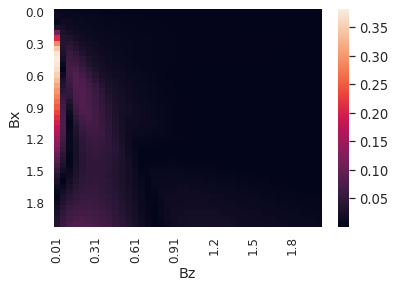

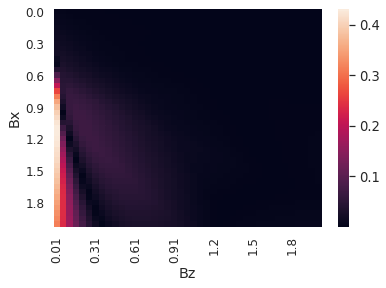

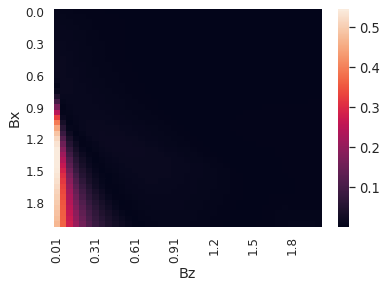

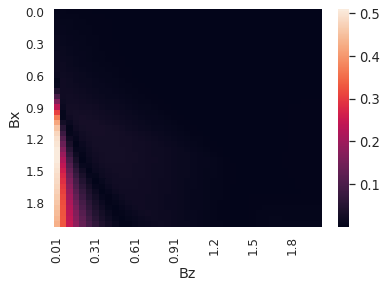

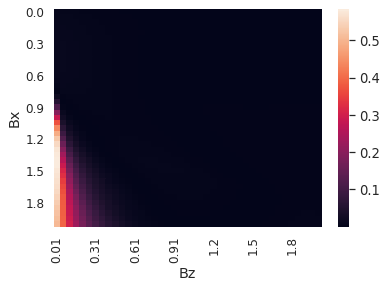

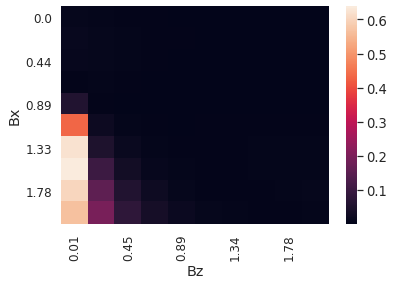

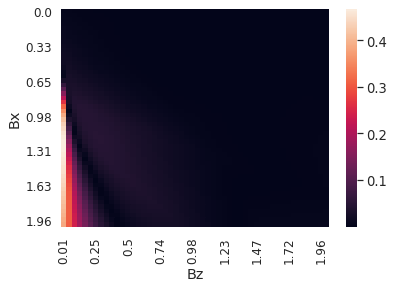

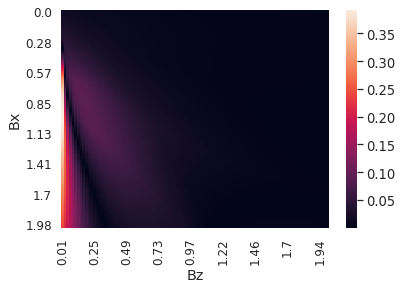

In [18]:
import pandas as pd
import seaborn as sns
data_graph = np.load(t_data_2)
Bx = data_graph['fields'].T[2]
Bz = data_graph['fields'].T[4]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]

sns.set(font_scale=1.2)

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_2,mag_2_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_4)
Bx = data_graph['fields'].T[4]
Bz = data_graph['fields'].T[8]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_4,mag_4_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_7)
Bx = data_graph['fields'].T[7]
Bz = data_graph['fields'].T[14]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_7,mag_7_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_6,mag_6_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_8)
Bx = data_graph['fields'].T[8]
Bz = data_graph['fields'].T[16]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_8,mag_8_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_10,mag_10_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.show()

data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_5,mag_5_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_3,mag_3_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

In [ ]:
x = [100,529,10000]

for i in x:
    if(i==64):
        data_2 = '2_qubit_64_data.npz'
        data_4 = '4_qubit_64_data.npz'
        data_7 = '7_qubit_64_data.npz'
        
    elif(i==100):
        data_2 = '2_qubit_100_data.npz'
        data_4 = '4_qubit_100_data.npz'
        data_7 = '7_qubit_100_data.npz'
        
    elif(i==529):
        data_2 = '2_qubit_500_data.npz'
        data_4 = '4_qubit_500_data.npz'
        data_7 = '7_qubit_500_data.npz'
    
    elif(i==10000):
        data_2 = '2_qubit_10000_data.npz'
        data_4 = '4_qubit_10000_data.npz'
        data_7 = '7_qubit_10000_data.npz'
    

    validation_n_sizes = [6,8]
    mps_size = 5
    device = torch.device("cpu")
    model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_sizes = [2,4,7]
    val_sizes = [6,8,2,4,7]

    pool_size = 10000

    val_size = 1089

    val_data_2 = get_dataset(v_data_2, 2, val_size)
    val_data_4 = get_dataset(v_data_4, 4, val_size)
    val_data_7 = get_dataset(v_data_7, 7, val_size)
    val_data_6 = get_dataset(data_6, 6, pool_size)
    val_data_8 = get_dataset(data_8, 8, 2500)


    test_data_3 = get_dataset(data_3, 3, pool_size)
    test_data_5 = get_dataset(data_5, 5, 2500)
    test_data_10 = get_dataset(data_10, 10, 100)

    val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

    val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]


    val_6 = next(iter(val_loaders[0]))
    val_8 = next(iter(val_loaders[1]))
    val_2 = next(iter(val_loaders[2]))
    val_4 = next(iter(val_loaders[3]))
    val_7 = next(iter(val_loaders[4]))
    
    training_data_2 = auto_encoder.get_dataset(data_2,2,i)
    training_data_4 = auto_encoder.get_dataset(data_4,4,i)
    training_data_7 = auto_encoder.get_dataset(data_7,7,i) 
    
    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [test_data_2, test_data_3, test_data_4, test_data_5, test_data_6, test_data_7, test_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

    print(round(mean_error(data_y_2,data_y_2_t),4), "&", round(mean_error(data_y_3,data_y_3_t),4), "&", round(mean_error(data_y_4,data_y_4_t),4), "&", round(mean_error(data_y_5,data_y_5_t),4), "&", round(mean_error(data_y_6,data_y_6_t),4), "&",  round(mean_error(data_y_7,data_y_7_t),4), "&", round(mean_error(data_y_8,data_y_8_t),4), "&", round(mean_error(data_y_10,data_y_10_t),4))
    


Training Validation  0
Epoch 2 : 	 Training_Error: 1.59420 	 Val Error: 0.64011
********************************************************************************
2_qubit_loss: 0.12150 	 	 |4_qubit_loss: 0.13902 	 	 |7_qubit_loss: 1.33368 	 	 |
********************************************************************************
6_qubit_loss: 0.10916 	 	 |8_qubit_loss: 0.16185 	 	 |2_qubit_loss: 0.04218 	 	 |4_qubit_loss: 0.06872 	 	 |7_qubit_loss: 0.25820 	 	 |



Epoch 4 : 	 Training_Error: 0.53538 	 Val Error: 0.39445
********************************************************************************
2_qubit_loss: 0.05613 	 	 |4_qubit_loss: 0.13217 	 	 |7_qubit_loss: 0.34707 	 	 |
********************************************************************************
6_qubit_loss: 0.08150 	 	 |8_qubit_loss: 0.11107 	 	 |2_qubit_loss: 0.03965 	 	 |4_qubit_loss: 0.06028 	 	 |7_qubit_loss: 0.10195 	 	 |



Epoch 6 : 	 Training_Error: 0.29510 	 Val Error: 0.35877
****************************************

Epoch 10 : 	 Training_Error: 0.06115 	 Val Error: 0.07500
********************************************************************************
2_qubit_loss: 0.00788 	 	 |4_qubit_loss: 0.01463 	 	 |7_qubit_loss: 0.03864 	 	 |
********************************************************************************
6_qubit_loss: 0.01370 	 	 |8_qubit_loss: 0.01201 	 	 |2_qubit_loss: 0.01381 	 	 |4_qubit_loss: 0.02180 	 	 |7_qubit_loss: 0.01369 	 	 |



Epoch 12 : 	 Training_Error: 0.05160 	 Val Error: 0.05124
********************************************************************************
2_qubit_loss: 0.00773 	 	 |4_qubit_loss: 0.01030 	 	 |7_qubit_loss: 0.03357 	 	 |
********************************************************************************
6_qubit_loss: 0.00837 	 	 |8_qubit_loss: 0.01030 	 	 |2_qubit_loss: 0.00926 	 	 |4_qubit_loss: 0.01307 	 	 |7_qubit_loss: 0.01024 	 	 |



Epoch 14 : 	 Training_Error: 0.05631 	 Val Error: 0.06451
************************************************************

Epoch 22 : 	 Training_Error: 0.00362 	 Val Error: 0.01258
********************************************************************************
2_qubit_loss: 0.00053 	 	 |4_qubit_loss: 0.00087 	 	 |7_qubit_loss: 0.00222 	 	 |
********************************************************************************
6_qubit_loss: 0.00165 	 	 |8_qubit_loss: 0.00115 	 	 |2_qubit_loss: 0.00416 	 	 |4_qubit_loss: 0.00448 	 	 |7_qubit_loss: 0.00114 	 	 |



Epoch 24 : 	 Training_Error: 0.00347 	 Val Error: 0.01112
********************************************************************************
2_qubit_loss: 0.00062 	 	 |4_qubit_loss: 0.00093 	 	 |7_qubit_loss: 0.00193 	 	 |
********************************************************************************
6_qubit_loss: 0.00173 	 	 |8_qubit_loss: 0.00092 	 	 |2_qubit_loss: 0.00325 	 	 |4_qubit_loss: 0.00399 	 	 |7_qubit_loss: 0.00123 	 	 |



Epoch 26 : 	 Training_Error: 0.00281 	 Val Error: 0.01269
************************************************************

In [ ]:
import pandas as pd
import seaborn as sns
data_graph = np.load(t_data_2)
Bx = data_graph['fields'].T[2]
Bz = data_graph['fields'].T[4]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]

sns.set(font_scale=1.2)

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_2,mag_2_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_4)
Bx = data_graph['fields'].T[4]
Bz = data_graph['fields'].T[8]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_4,mag_4_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_7)
Bx = data_graph['fields'].T[7]
Bz = data_graph['fields'].T[14]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_7,mag_7_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_6,mag_6_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_8)
Bx = data_graph['fields'].T[8]
Bz = data_graph['fields'].T[16]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_8,mag_8_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_10,mag_10_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.show()

data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_5,mag_5_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_3,mag_3_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-27-acb3b386217b>:27: RuntimeWarning: More tha

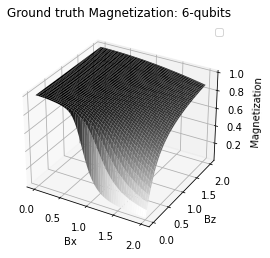

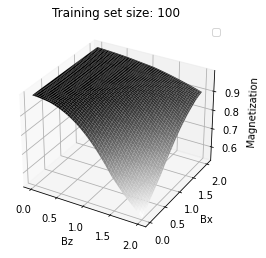

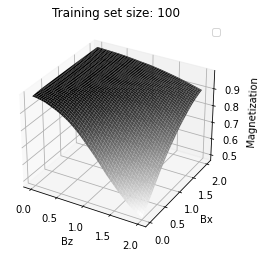

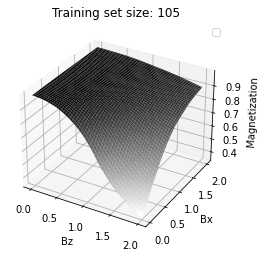

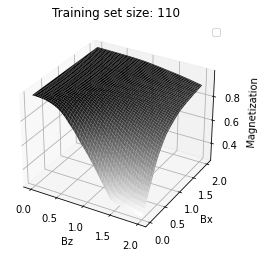

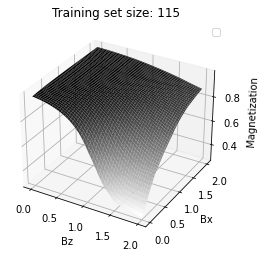

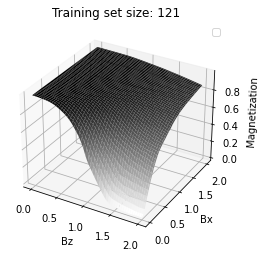

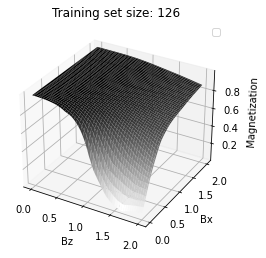

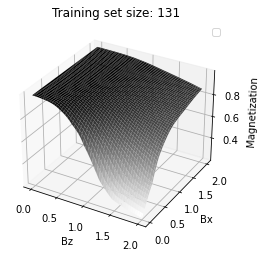

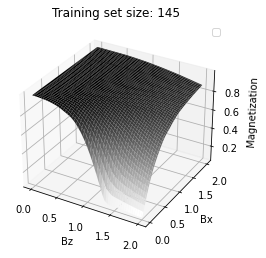

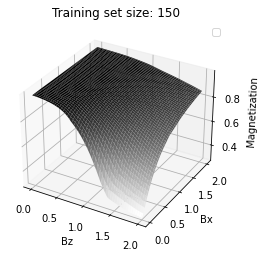

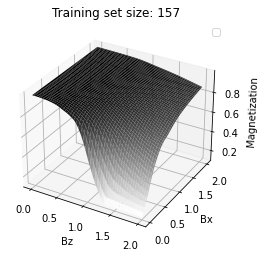

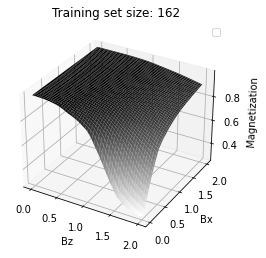

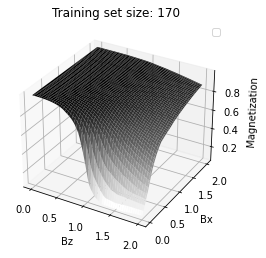

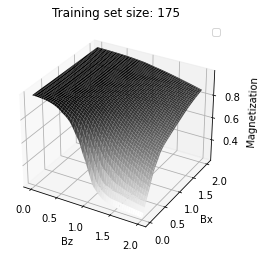

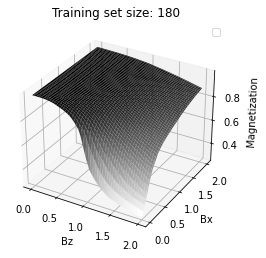

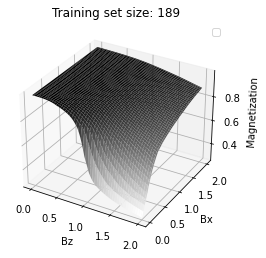

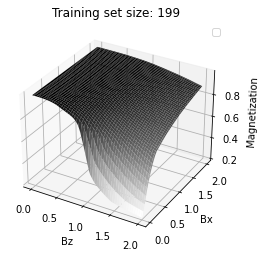

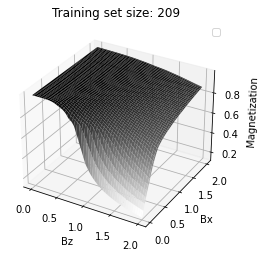

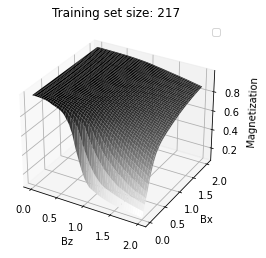

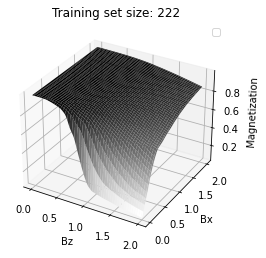

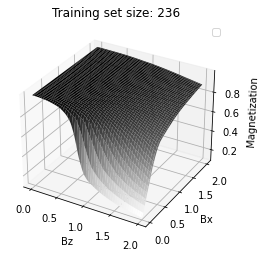

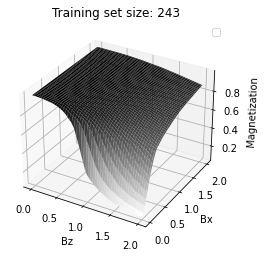

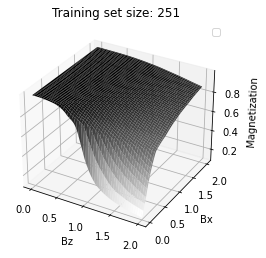

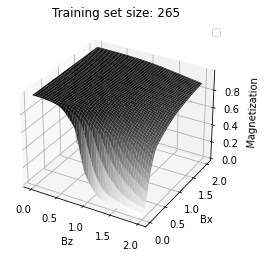

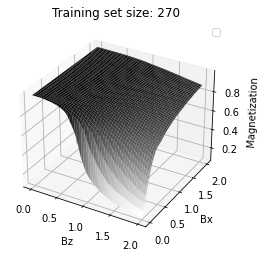

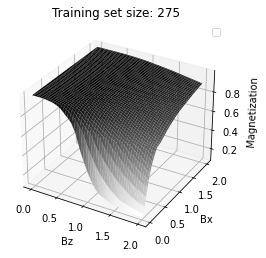

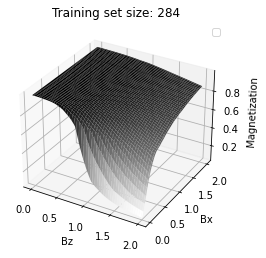

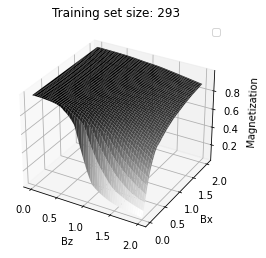

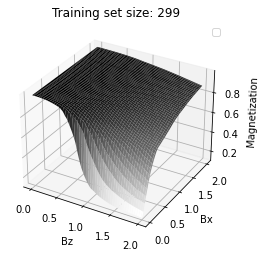

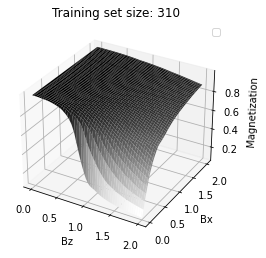

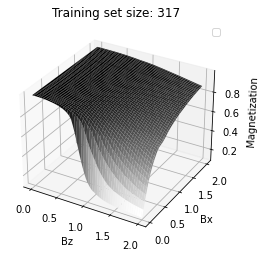

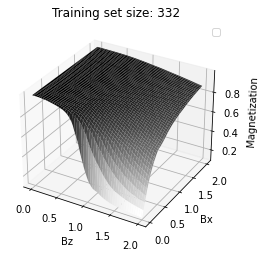

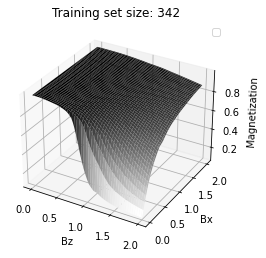

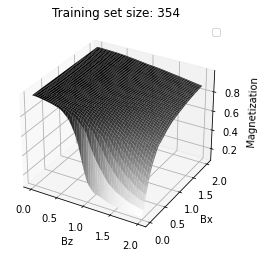

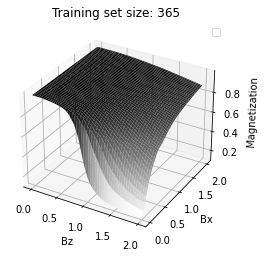

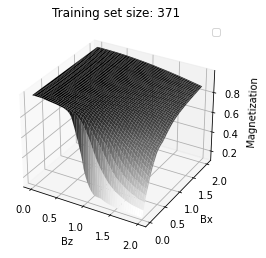

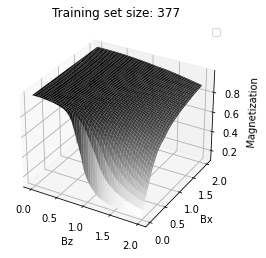

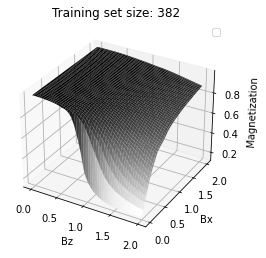

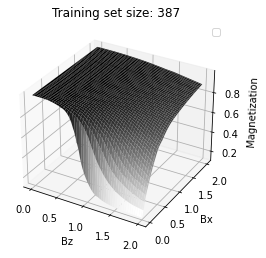

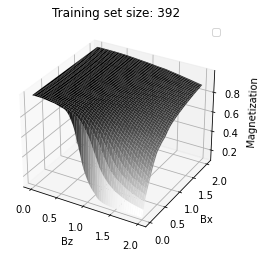

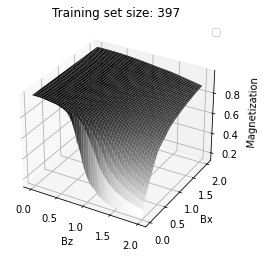

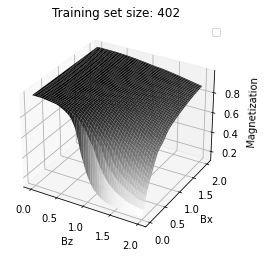

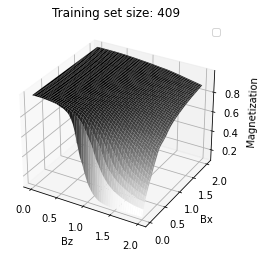

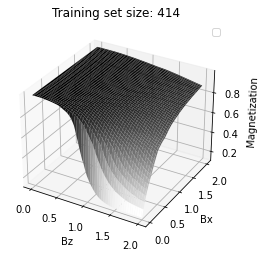

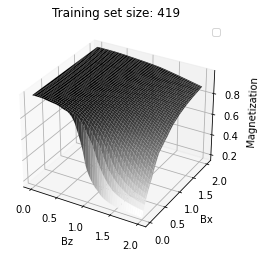

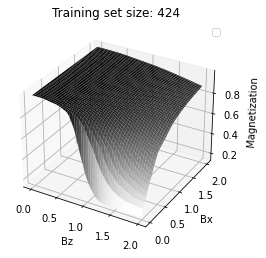

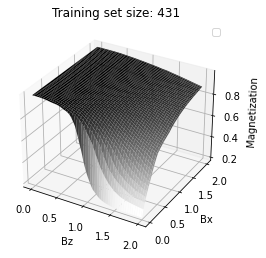

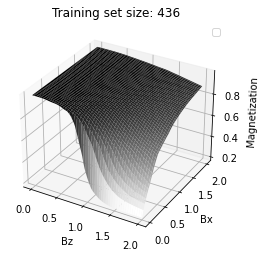

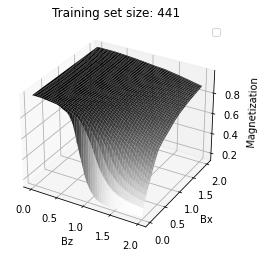

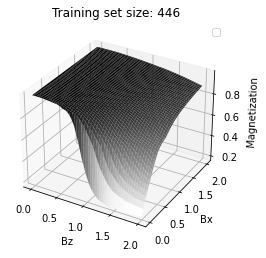

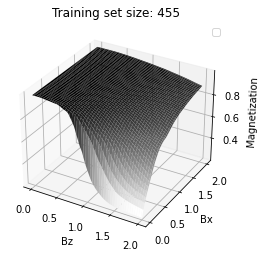

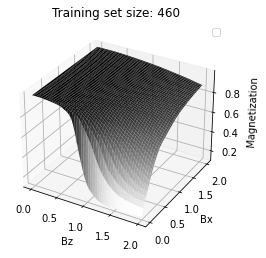

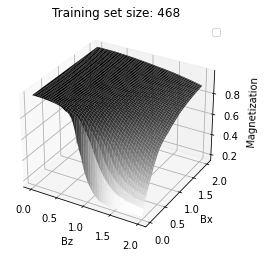

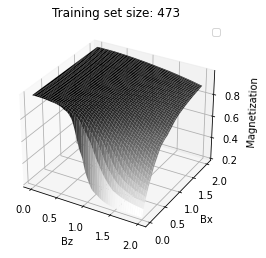

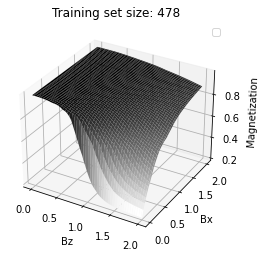

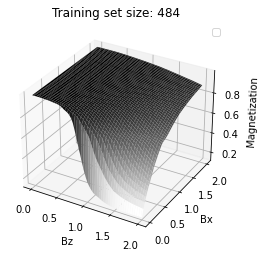

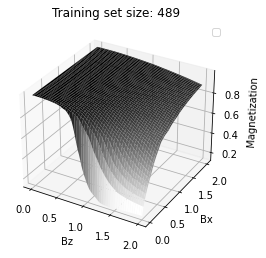

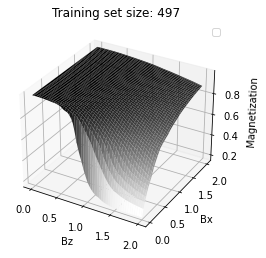

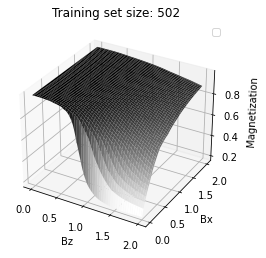

In [27]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (100, 100))
y = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 6-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Training set size: "+ str(sizes[i])
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")
    

In [22]:
y = np.reshape(Bx, (100, 100))
x = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 6-qubits")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

NameError: name 'Bx' is not defined

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

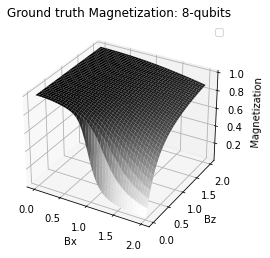

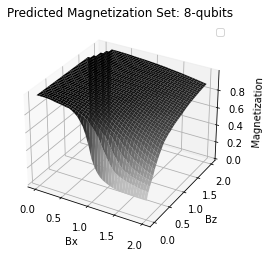

In [31]:

data_graph = np.load(t_data_8)
Bx = data_graph['fields'].T[8]
Bz = data_graph['fields'].T[16]

x = np.reshape(Bx, (41, 41))
y = np.reshape(Bz, (41, 41))
z = np.reshape(mag_8_t, (41, 41))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 8-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_8, (41, 41))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 8-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

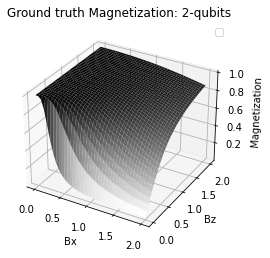

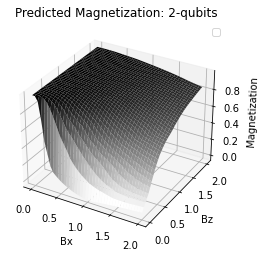

In [32]:
data_graph = np.load(t_data_2)
Bx = data_graph['fields'].T[2]
Bz = data_graph['fields'].T[4]

x = np.reshape(Bx, (41, 41))
y = np.reshape(Bz, (41, 41))
z = np.reshape(mag_2_t, (41, 41))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 2-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_2, (41, 41))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 2-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

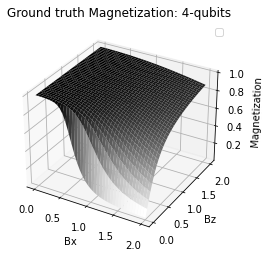

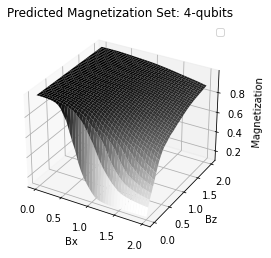

In [33]:
data_graph = np.load(t_data_4)
Bx = data_graph['fields'].T[4]
Bz = data_graph['fields'].T[8]

x = np.reshape(Bx, (41, 41))
y = np.reshape(Bz, (41, 41))
z = np.reshape(mag_4_t, (41, 41))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 4-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_4, (41, 41))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 4-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

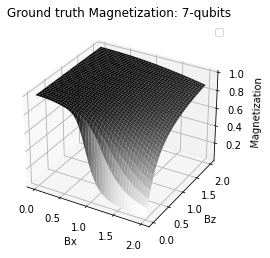

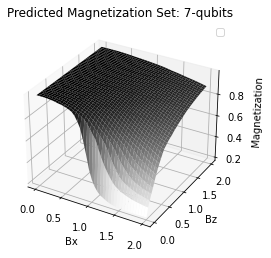

In [34]:
data_graph = np.load(t_data_7)
Bx = data_graph['fields'].T[7]
Bz = data_graph['fields'].T[14]

x = np.reshape(Bx, (41, 41))
y = np.reshape(Bz, (41, 41))
z = np.reshape(mag_7_t, (41, 41))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 7-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_7, (41, 41))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 7-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

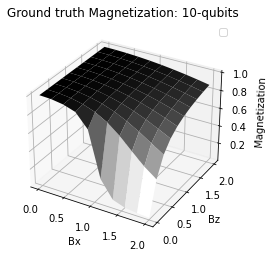

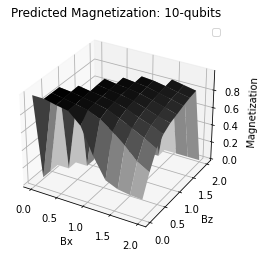

In [35]:
data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

x = np.reshape(Bx, (10, 10))
y = np.reshape(Bz, (10, 10))
z = np.reshape(mag_10_t, (10, 10))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 10-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_10, (10, 10))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 10-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

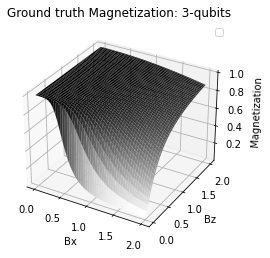

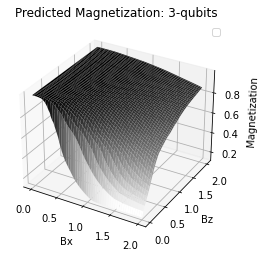

In [36]:
data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

x = np.reshape(Bx, (100, 100))
y = np.reshape(Bz, (100, 100))
z = np.reshape(mag_3_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 3-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_3, (100, 100))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 3-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

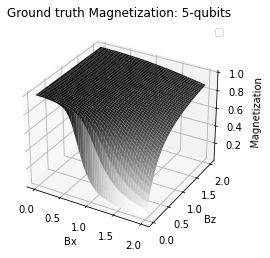

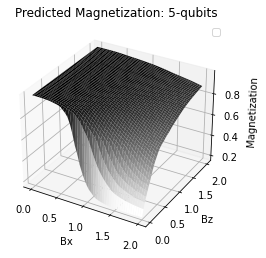

In [37]:
data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

x = np.reshape(Bx, (50, 50))
y = np.reshape(Bz, (50, 50))
z = np.reshape(mag_5_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 5-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_5, (50, 50))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 5-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

Set  0 :


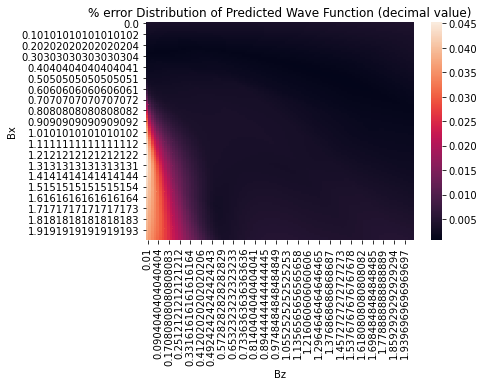

Set  1 :


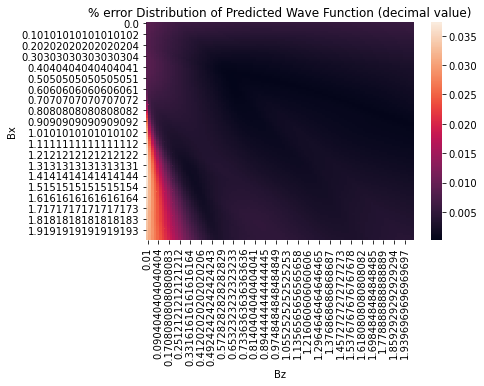

Set  2 :


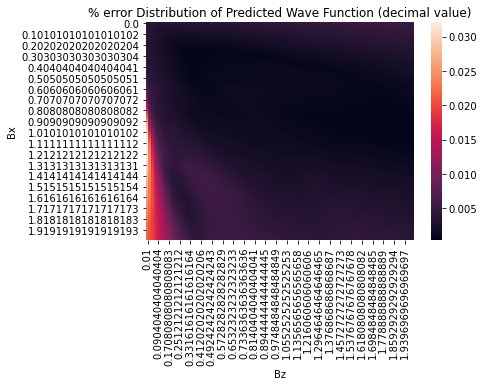

Set  3 :


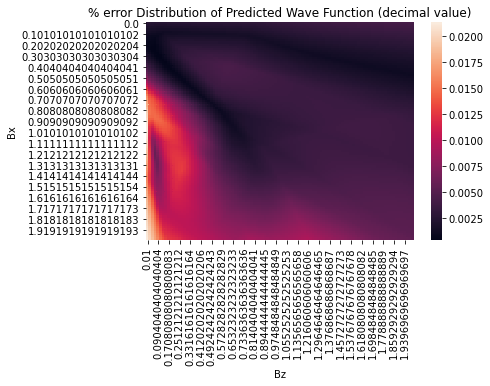

Set  4 :


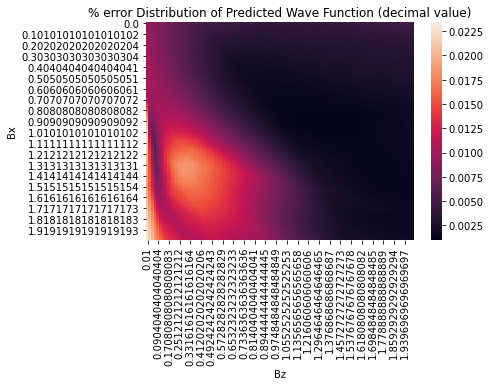

Set  5 :


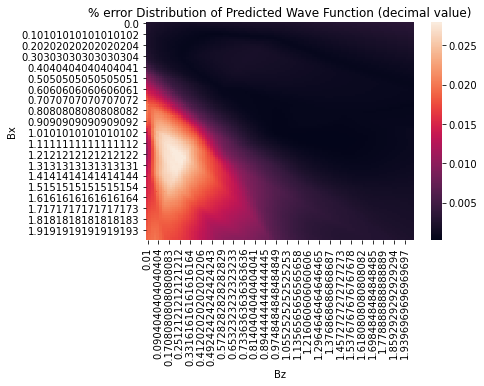

Set  6 :


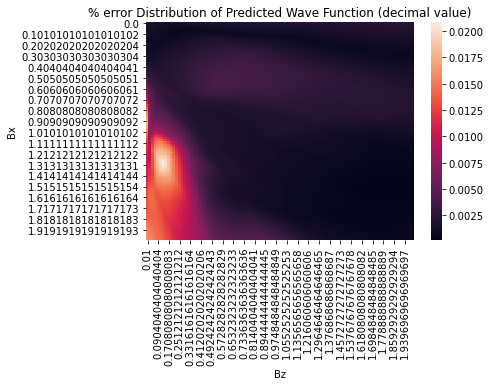

Set  7 :


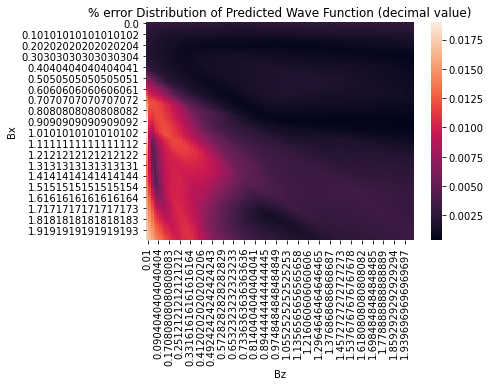

Set  8 :


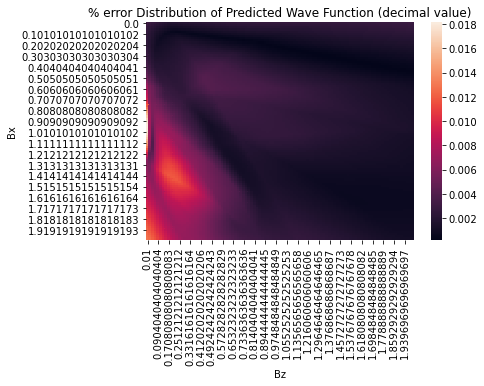

Set  9 :


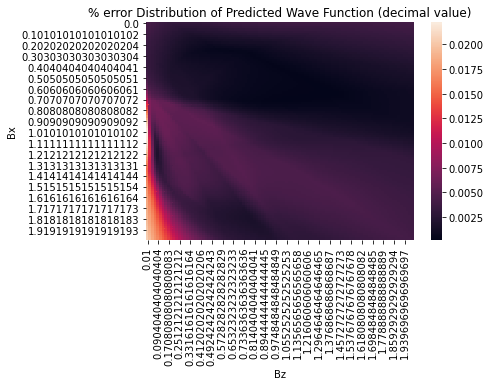

Set  10 :


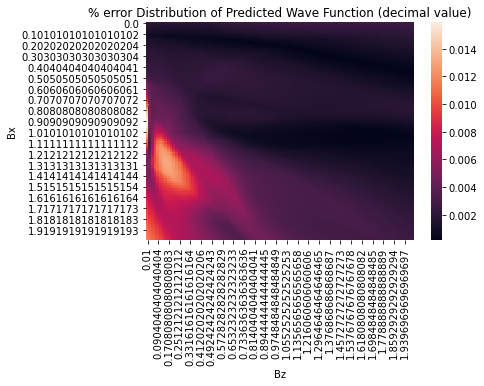

Set  11 :


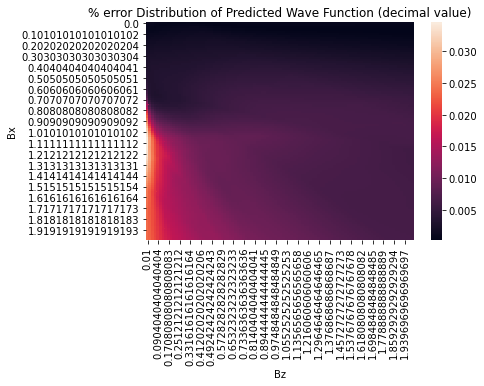

Set  12 :


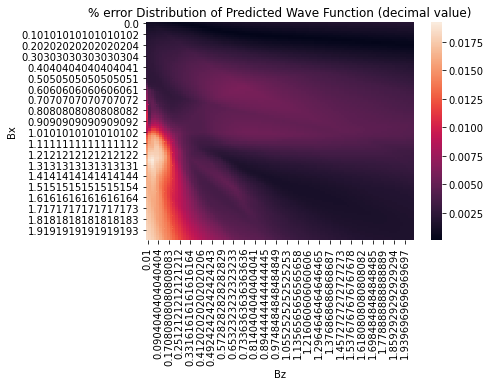

Set  13 :


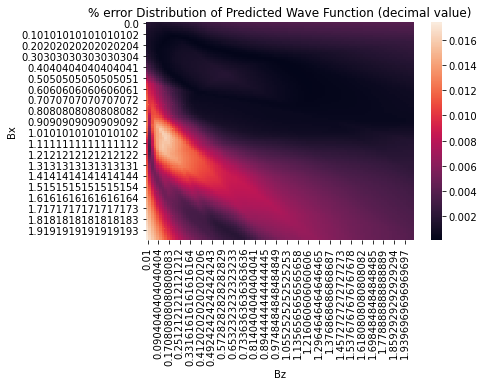

Set  14 :


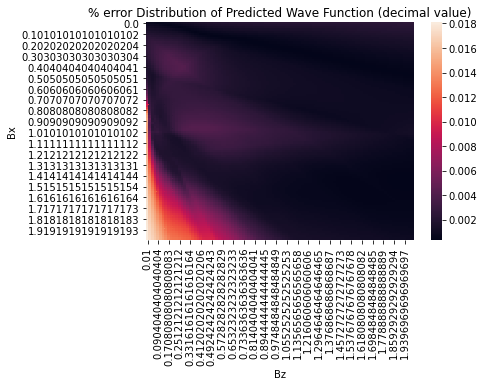

Set  15 :


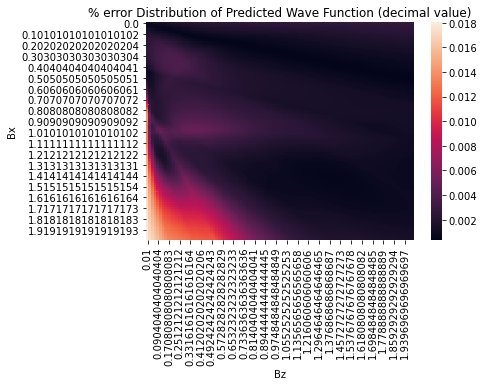

Set  16 :


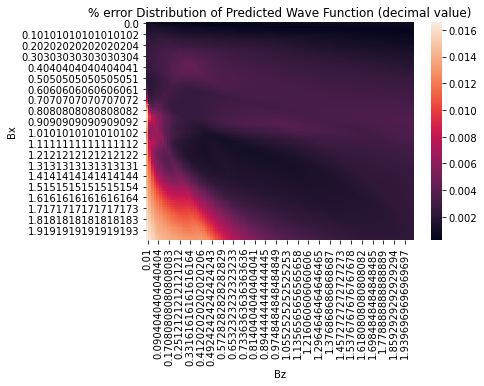

Set  17 :


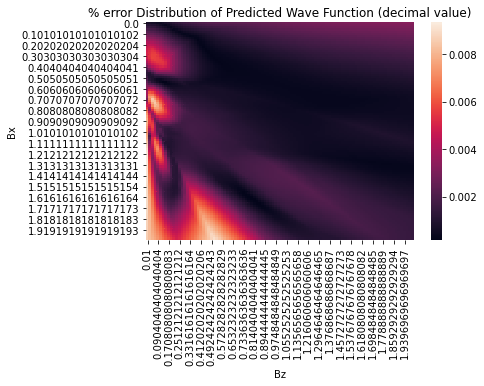

Set  18 :


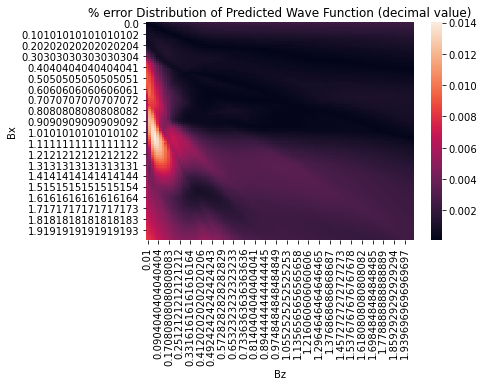

Set  19 :


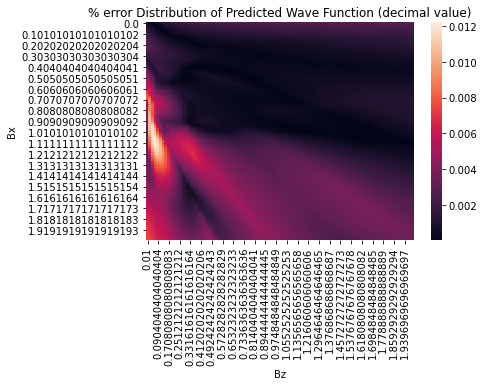

Set  20 :


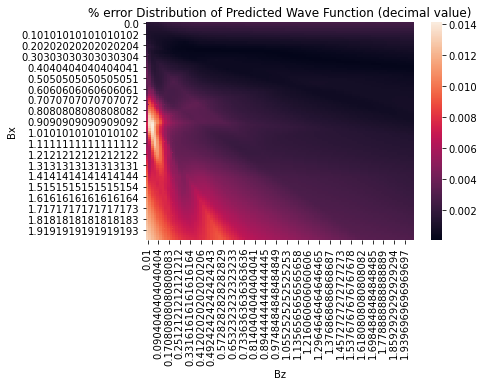

Set  21 :


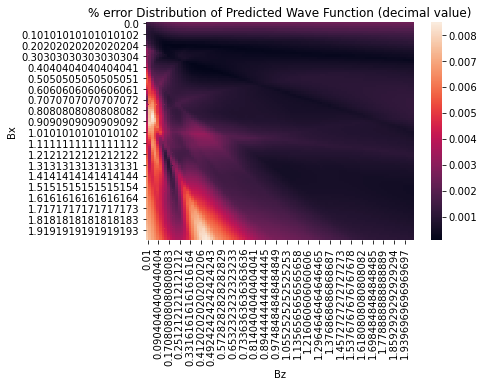

Set  22 :


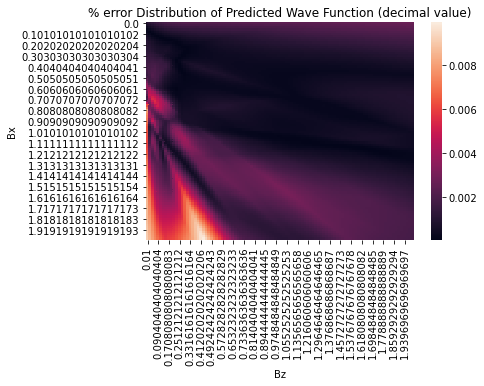

Set  23 :


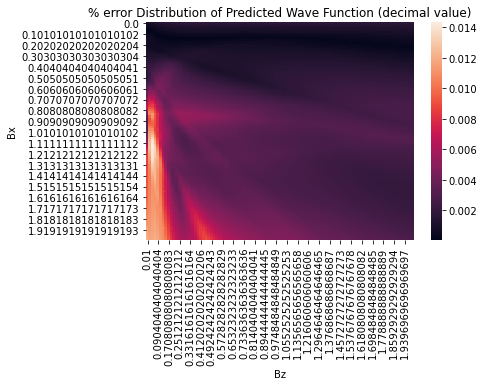

Set  24 :


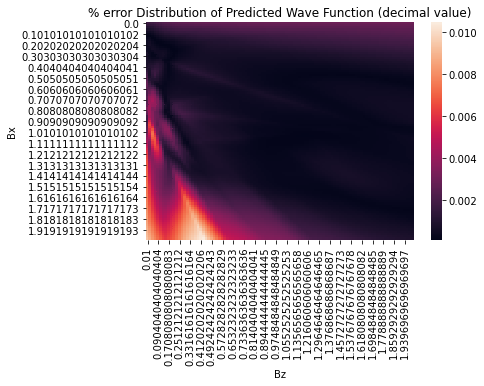

Set  25 :


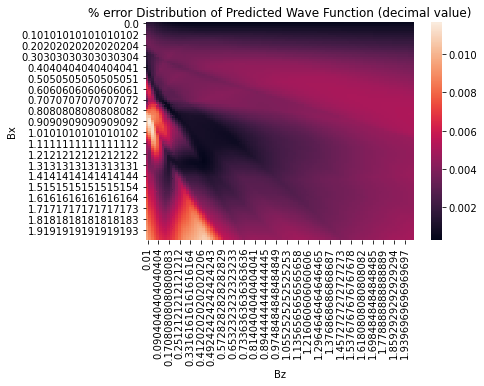

Set  26 :


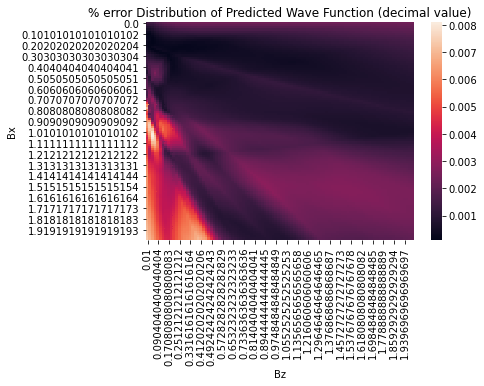

Set  27 :


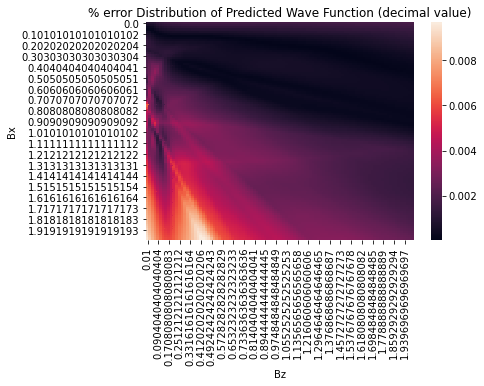

Set  28 :


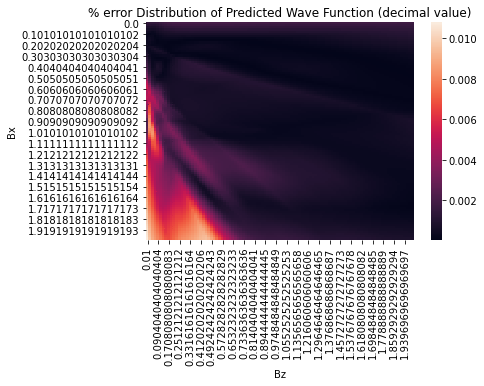

Set  29 :


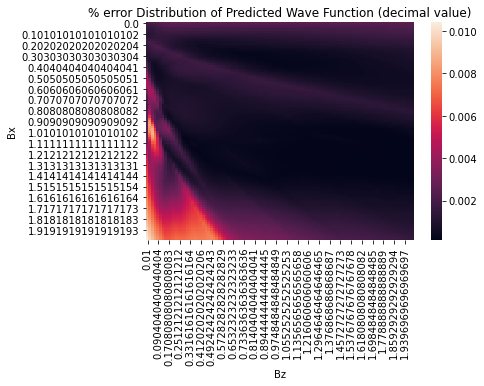

Set  30 :


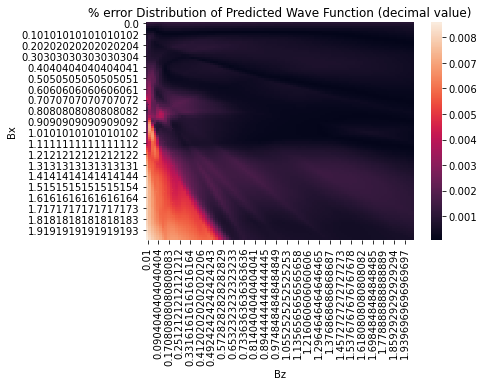

Set  31 :


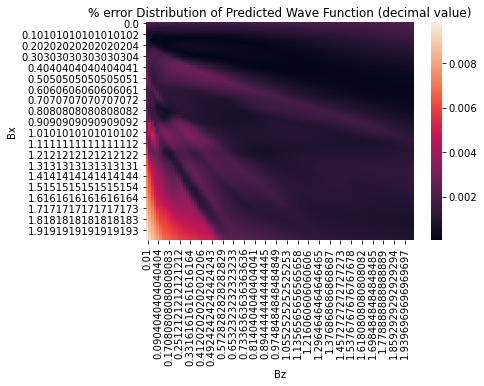

Set  32 :


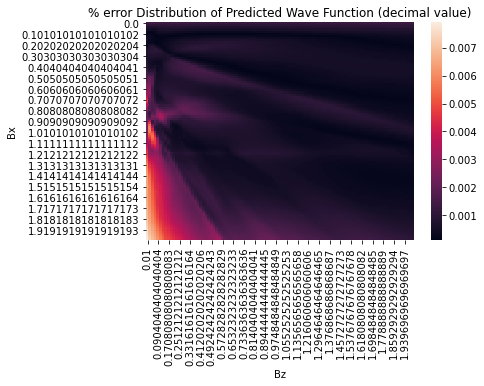

Set  33 :


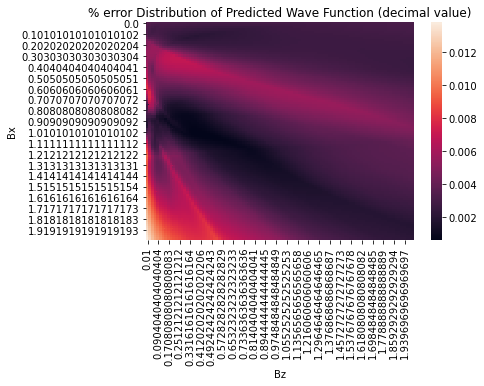

Set  34 :


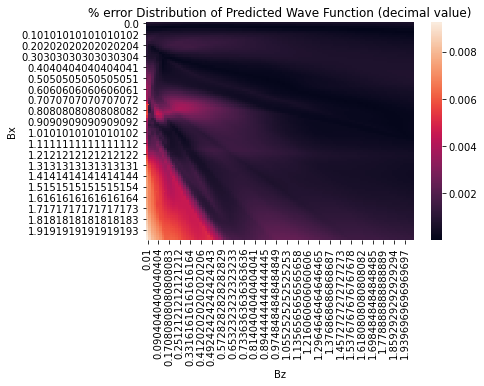

Set  35 :


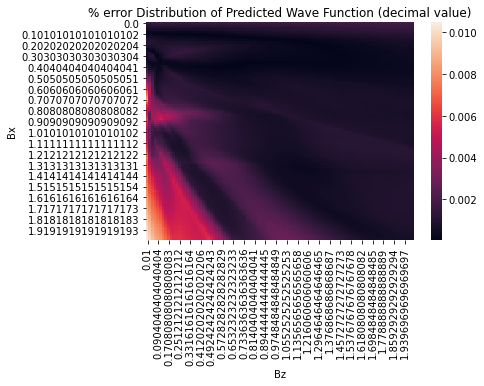

Set  36 :


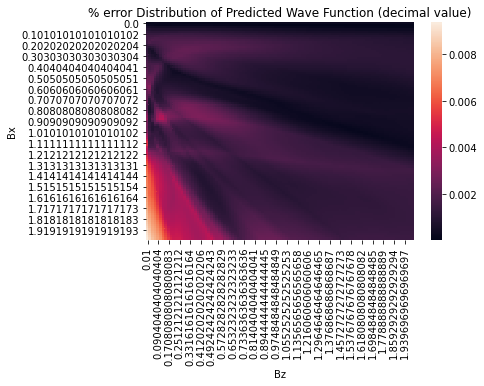

Set  37 :


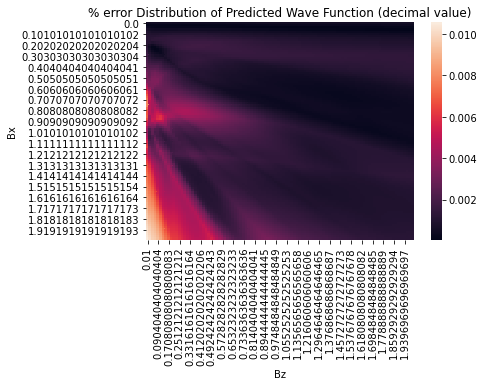

Set  38 :


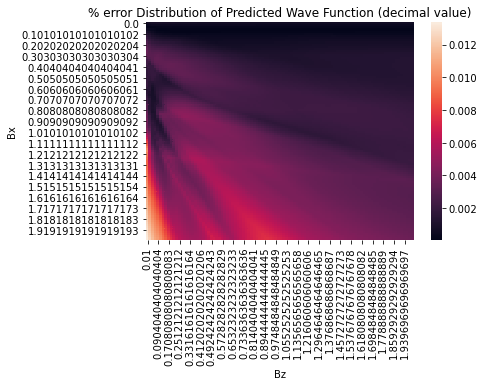

Set  39 :


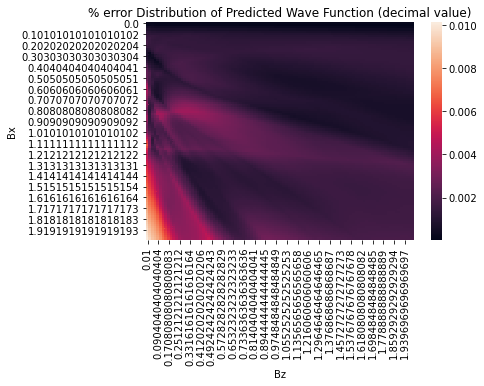

Set  40 :


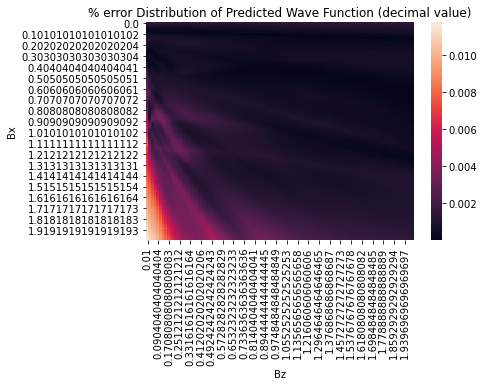

Set  41 :


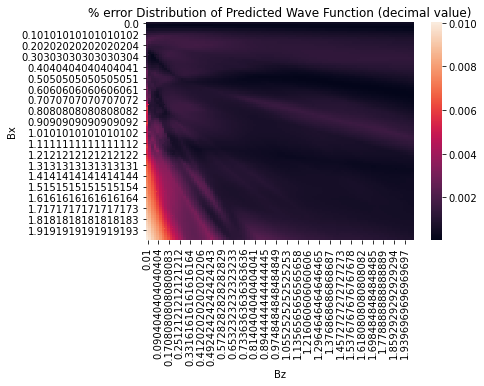

Set  42 :


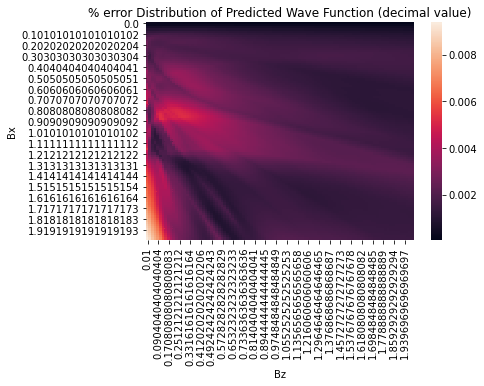

Set  43 :


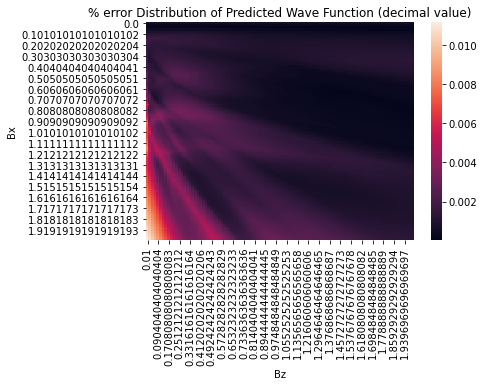

Set  44 :


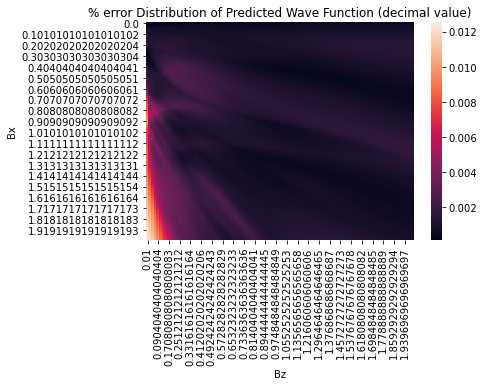

Set  45 :


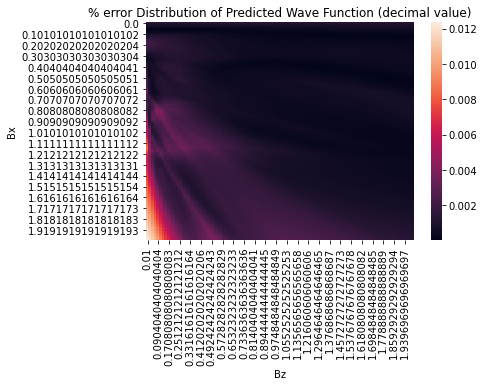

Set  46 :


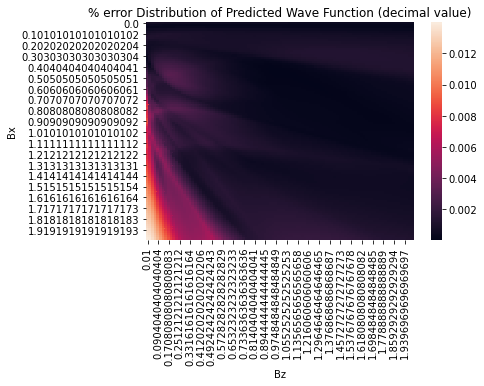

Set  47 :


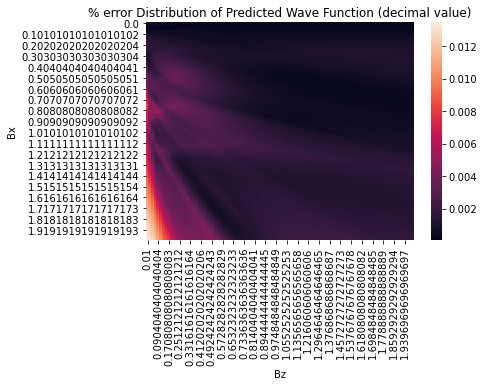

Set  48 :


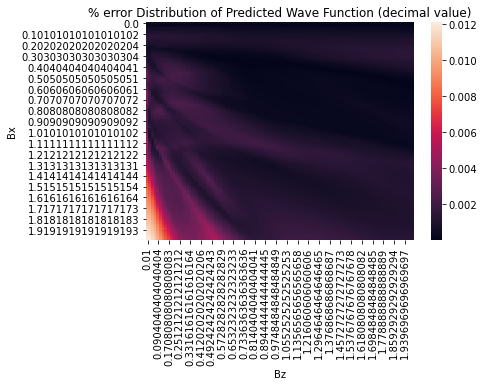

Set  49 :


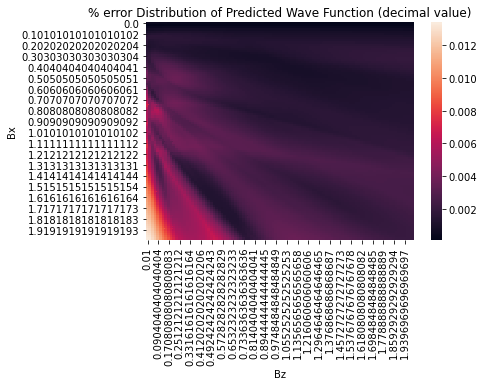

Set  50 :


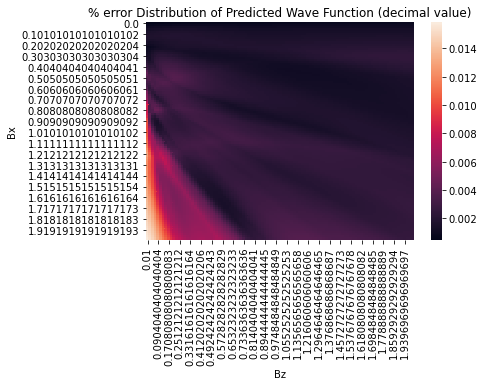

Set  51 :


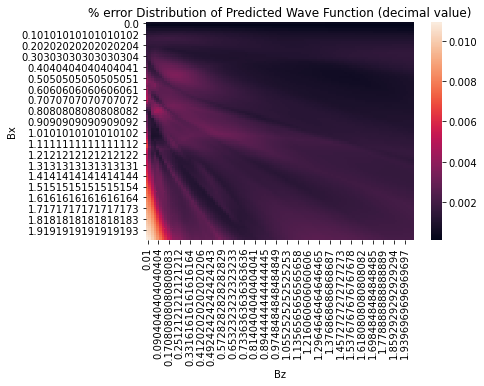

Set  52 :


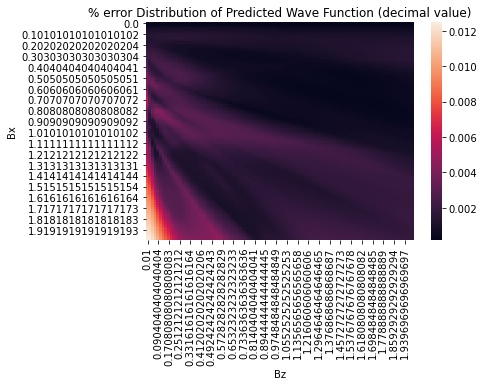

Set  53 :


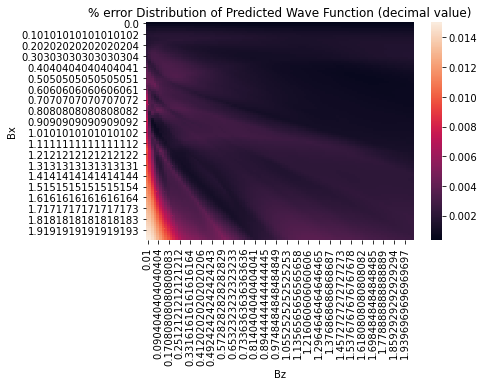

Set  54 :


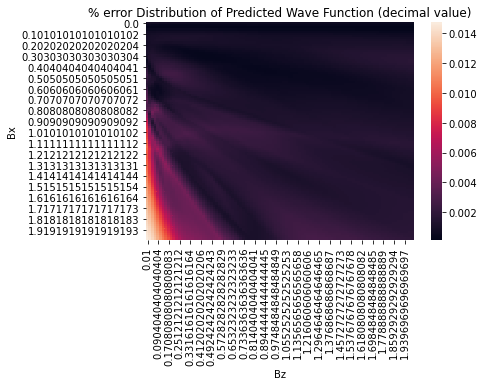

Set  55 :


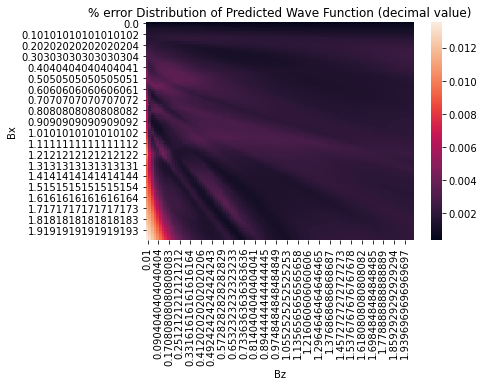

Set  56 :


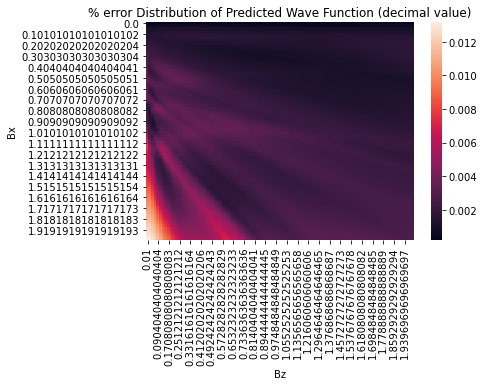

Set  57 :


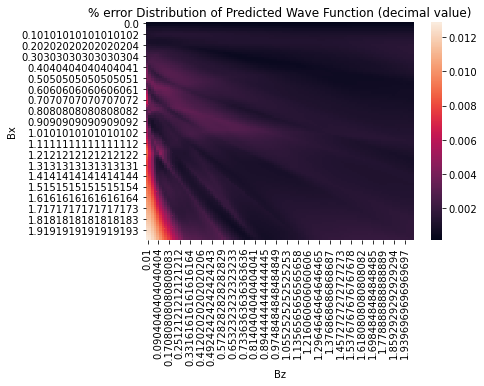

Set  58 :


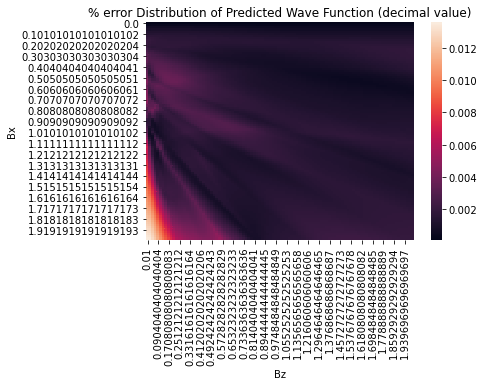

In [38]:
import pandas as pd
import seaborn as sns

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

count = 0
for i in error_p:
    print("Set ", count,":")
    data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': i})
    data = data.pivot(index='Bx', columns='Bz', values='% error')
#    plt.hist2d(Bx, By, bins=N_bins, cmap='plasma')
    sns.heatmap(data)

    # Plot a colorbar with label.
#    cb = plt.colorbar()

    # Add title and labels to plot.
    plt.title('% error Distribution of Predicted Wave Function (decimal value)')
#     plt.xlabel('Bx')
#     plt.ylabel('Bz')

    # Show the plot.
    plt.show()
    count+=1

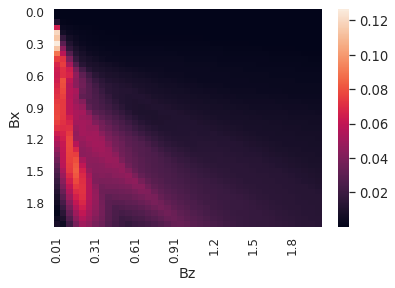

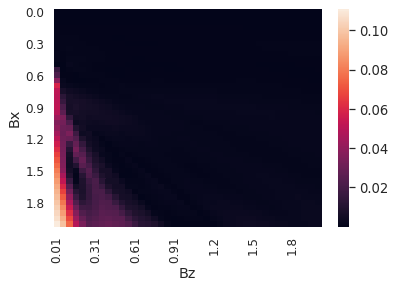

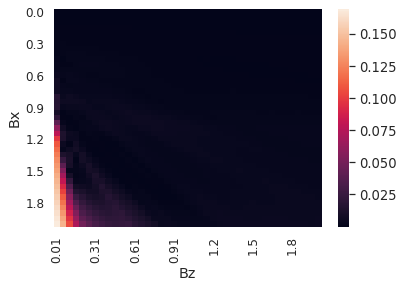

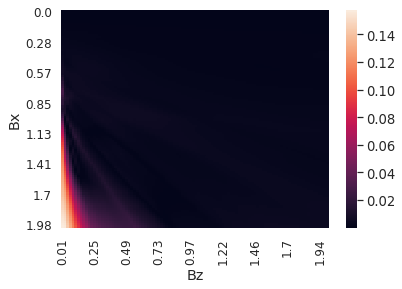

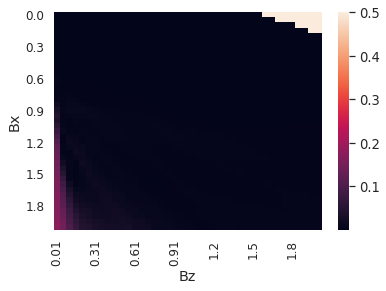

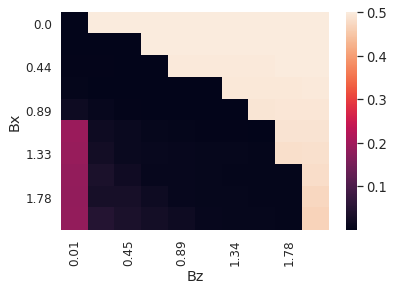

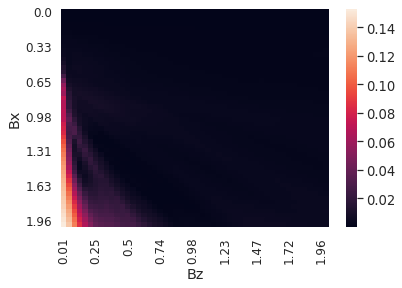

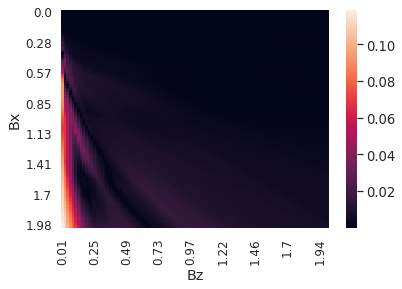

In [40]:
data_graph = np.load(t_data_2)
Bx = data_graph['fields'].T[2]
Bz = data_graph['fields'].T[4]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]

sns.set(font_scale=1.2)

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_2,mag_2_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_4)
Bx = data_graph['fields'].T[4]
Bz = data_graph['fields'].T[8]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_4,mag_4_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_7)
Bx = data_graph['fields'].T[7]
Bz = data_graph['fields'].T[14]
Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_7,mag_7_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_6,mag_6_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(t_data_8)
Bx = data_graph['fields'].T[8]
Bz = data_graph['fields'].T[16]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_8,mag_8_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_10,mag_10_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.show()

data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_5,mag_5_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

Bx=[round(i,2) for i in Bx]
Bz=[round(i,2) for i in Bz]
data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_mag(mag_3,mag_3_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
res = sns.heatmap(data)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

for index, label in enumerate(res.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
for index, label in enumerate(res.get_yticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

plt.show()

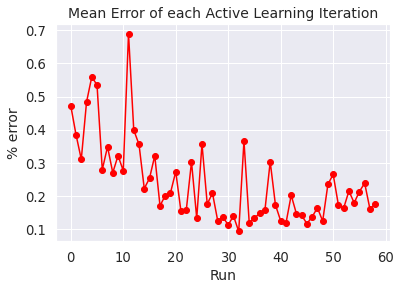

In [41]:
mean_dat = np.mean(error_p,axis = 1) * 100

x_ax = np.arange(len(mean_dat))

plt.plot(x_ax, mean_dat, color='red', marker='o')
plt.title('Mean Error of each Active Learning Iteration', fontsize=14)
plt.xlabel('Run', fontsize=14)
plt.ylabel('% error', fontsize=14)
plt.grid(True)
plt.show()

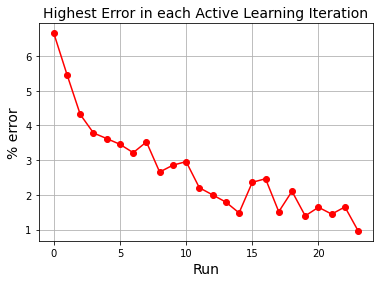

In [65]:
sorted_data = np.sort(error_p, axis = 1)
max_dat = []
for i in sorted_data:
    max_dat.append(i[len(i)-1]*100)

plt.plot(x_ax, max_dat, color='red', marker='o')
plt.title('Highest Error in each Active Learning Iteration', fontsize=14)
plt.xlabel('Run', fontsize=14)
plt.ylabel('% error', fontsize=14)
plt.grid(True)
plt.show()